# Pre-requisites

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import shutil
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid


# Test Analysis

## Data

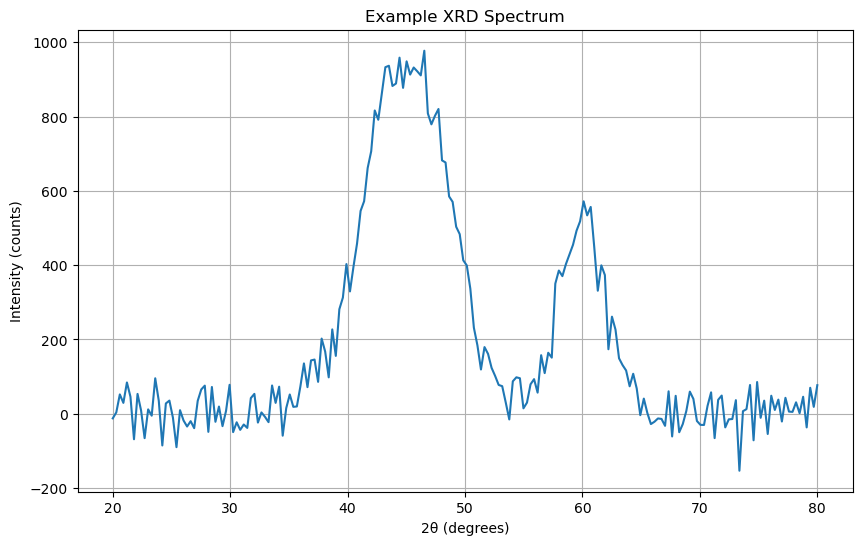

Detected Peaks:
      TwoTheta   Intensity
59   37.788945  202.295981
62   38.693467  226.932327
64   39.296482  281.266023
65   39.597990  312.685855
66   39.899497  402.840132
67   40.201005  329.231778
68   40.502513  396.274792
69   40.804020  458.259581
70   41.105528  545.937539
71   41.407035  572.114870
72   41.708543  661.501070
73   42.010050  706.632341
74   42.311558  816.398423
75   42.613065  791.402007
76   42.914573  861.888436
77   43.216080  932.884396
78   43.517588  936.811427
79   43.819095  882.359477
80   44.120603  888.953363
81   44.422111  958.566496
82   44.723618  877.294929
83   45.025126  948.665363
84   45.326633  913.026192
85   45.628141  932.038987
86   45.929648  921.906842
87   46.231156  910.879976
88   46.532663  977.253485
89   46.834171  808.517759
90   47.135678  779.073738
91   47.437186  801.847819
92   47.738693  820.364356
93   48.040201  682.032184
94   48.341709  676.347246
95   48.643216  584.978343
96   48.944724  570.287203
97   49.2462

In [4]:
# Generate some example XRD spectra data
# This is just an example, replace with your actual data
two_theta = np.linspace(20, 80, 200)  # 2-theta values
intensity = 1000 * np.exp(-((two_theta - 45) / 5) ** 2) + \
            500 * np.exp(-((two_theta - 60) / 3) ** 2) + \
            np.random.normal(0, 50, size=two_theta.size)  # Intensity values with some noise

# Create a Pandas DataFrame to store the data
xrd_data = pd.DataFrame({'TwoTheta': two_theta, 'Intensity': intensity})

# Plot the XRD spectra
plt.figure(figsize=(10, 6))
plt.plot(xrd_data['TwoTheta'], xrd_data['Intensity'])
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (counts)')
plt.title('Example XRD Spectrum')
plt.grid(True)
plt.show()

# Basic analysis (peak detection - simple example)
# You would typically use a proper peak finding algorithm here
peak_threshold = 200  # Adjust this threshold as needed
peaks = xrd_data[xrd_data['Intensity'] > peak_threshold]

print("Detected Peaks:")
print(peaks)

## Intensity-Based Method (Segal Method)

In [10]:
# --- Step 2: Intensity-Based Method (Segal Method) ---
# Find the maximum peak (crystalline peak)
cryst_peak_idx = np.argmax(intensity)
I_cryst = intensity[cryst_peak_idx]
theta_cryst = two_theta[cryst_peak_idx]

# Estimate amorphous intensity as the local minimum near the crystalline peak
I_amorph = np.min(intensity[cryst_peak_idx-10:cryst_peak_idx+10])  # Adjust search window

# Compute crystallinity index
Xc_intensity = ((I_cryst - I_amorph) / I_cryst) * 100
print(f"Crystallinity (Intensity Method): {Xc_intensity:.2f}%")

Crystallinity (Intensity Method): 41.74%


## Area-Based Method (Peak Deconvolution)

### Iteration 1

In [ ]:
# --- Step 3: Area-Based Method (Peak Deconvolution) ---
# Smooth the spectrum to estimate amorphous background
smoothed_intensity = savgol_filter(intensity, window_length=51, polyorder=2)

# Detect crystalline peaks
peaks, _ = find_peaks(intensity, height=smoothed_intensity+5, prominence=10, width=2)

# Integrate crystalline peaks
Ac = trapezoid(intensity[peaks], two_theta[peaks])

# Integrate total area and subtract crystalline contribution for amorphous area
total_area = trapezoid(intensity, two_theta)
Aa = total_area - Ac

# Compute crystallinity index
Xc_area = (Ac / (Ac + Aa)) * 100
print(f"Crystallinity (Area Method): {Xc_area:.2f}%")

Crystallinity (Area Method): 189.00%


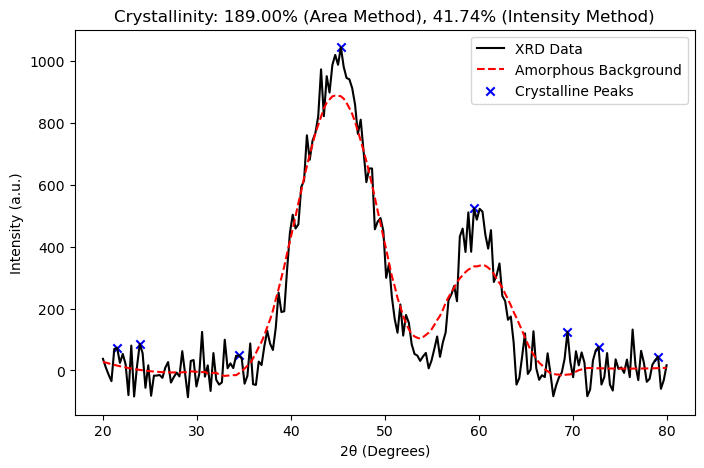

In [16]:
# --- Step 4: Plot Results ---
plt.figure(figsize=(8,5))
plt.plot(two_theta, intensity, label="XRD Data", color="black")
plt.plot(two_theta, smoothed_intensity, label="Amorphous Background", linestyle="dashed", color="red")
plt.scatter(two_theta[peaks], intensity[peaks], color="blue", marker="x", label="Crystalline Peaks")
plt.xlabel("2θ (Degrees)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.title(f"Crystallinity: {Xc_area:.2f}% (Area Method), {Xc_intensity:.2f}% (Intensity Method)")
plt.show()

### Iteration 2: Baseline Subtraction

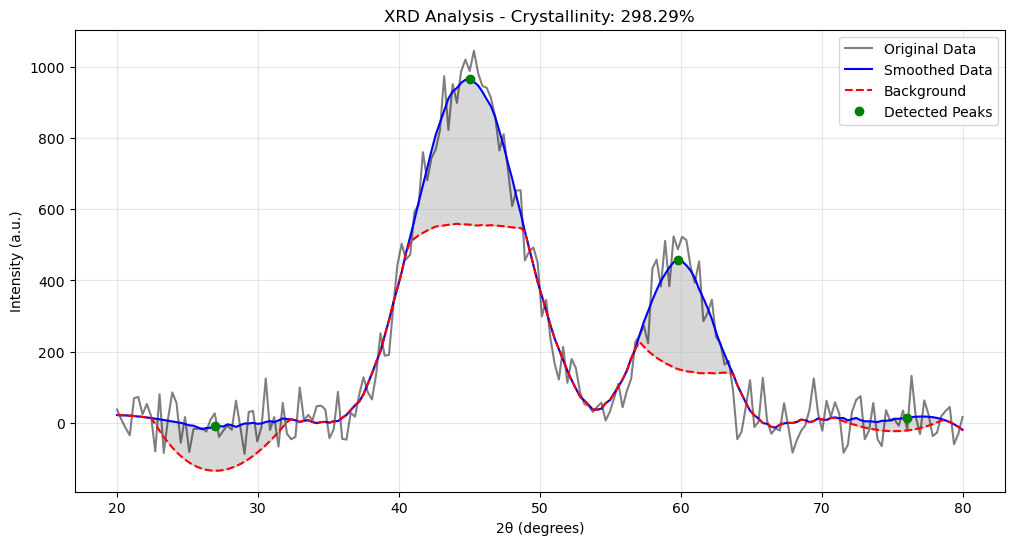

Crystallinity (Area Method): 298.29%


In [19]:
# --- Step 3: Area-Based Method with Improved Background Separation ---
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.integrate import trapezoid

# 1. First smooth the data to reduce noise
smoothed_intensity = savgol_filter(intensity, window_length=31, polyorder=3)

# 2. Estimate background using a wider window
background = savgol_filter(intensity, window_length=101, polyorder=3)
background = np.minimum(background, smoothed_intensity)  # Ensure background doesn't exceed signal

# 3. Subtract background to get peak-only signal
peaks_signal = smoothed_intensity - background

# 4. Find peaks in the background-subtracted signal
peaks, properties = find_peaks(peaks_signal,
                             height=10,          # Minimum peak height after background subtraction
                             distance=20,        # Minimum separation between peaks
                             prominence=5,       # Minimum peak prominence
                             width=2)           # Minimum peak width

# 5. Calculate areas
# Crystalline area (area of peaks above background)
Ac = trapezoid(peaks_signal[peaks], two_theta[peaks])

# Total area above background
total_area = trapezoid(peaks_signal, two_theta)

# Amorphous area
Aa = total_area - Ac

# 6. Compute crystallinity index
Xc_area = (Ac / total_area) * 100

# 7. Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, 'k-', label='Original Data', alpha=0.5)
plt.plot(two_theta, smoothed_intensity, 'b-', label='Smoothed Data')
plt.plot(two_theta, background, 'r--', label='Background')
plt.plot(two_theta[peaks], smoothed_intensity[peaks], 'go', label='Detected Peaks')
plt.fill_between(two_theta, background, smoothed_intensity, alpha=0.3, color='gray')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title(f'XRD Analysis - Crystallinity: {Xc_area:.2f}%')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Crystallinity (Area Method): {Xc_area:.2f}%")

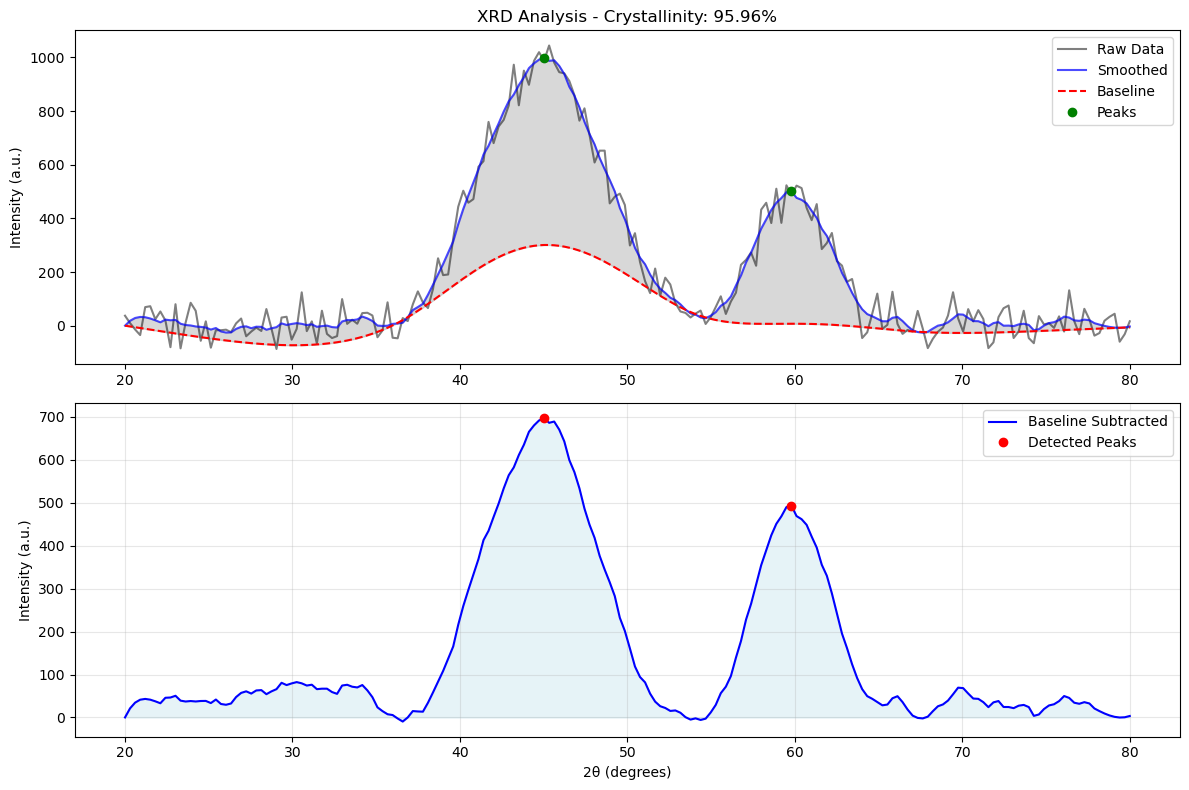

Crystallinity: 95.96%
Number of peaks detected: 2


In [ ]:
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.integrate import trapezoid
from scipy.optimize import minimize
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt


def detect_baseline_peaks(two_theta, intensity, visualise=True):
    """
    Automatic baseline detection and peak finding
    """
    # 1. Initial smoothing
    smoothed = savgol_filter(intensity, window_length=15, polyorder=3)
    
    # 2. Adaptive baseline detection
    def baseline_als(y, lam=100, p=0.001, niter=10):
        L = len(y)
        D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
        w = np.ones(L)
        for i in range(niter):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z
    
    # Calculate baseline
    baseline = baseline_als(smoothed, lam=100, p=0.001)
    
    # 3. Peak detection on baseline-subtracted data
    peaks_signal = smoothed - baseline
    peaks, properties = find_peaks(peaks_signal,
                                 height=np.std(peaks_signal)*2,
                                 distance=10,
                                 prominence=np.std(peaks_signal),
                                 width=2)
    
    # 4. Calculate areas
    crystalline_area = trapezoid(peaks_signal[peaks], two_theta[peaks])
    total_area = trapezoid(peaks_signal, two_theta)
    amorphous_area = total_area - crystalline_area
    
    # 5. Calculate crystallinity
    crystallinity = (crystalline_area / total_area) * 100
    
    if visualise:
        plt.figure(figsize=(12, 8))
        
        # Main plot
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, intensity, 'k-', label='Raw Data', alpha=0.5)
        plt.plot(two_theta, smoothed, 'b-', label='Smoothed', alpha=0.7)
        plt.plot(two_theta, baseline, 'r--', label='Baseline')
        plt.plot(two_theta[peaks], smoothed[peaks], 'go', label='Peaks')
        plt.fill_between(two_theta, baseline, smoothed, alpha=0.3, color='gray')
        plt.legend()
        plt.title(f'XRD Analysis - Crystallinity: {crystallinity:.2f}%')
        plt.ylabel('Intensity (a.u.)')
        
        # Baseline-subtracted plot
        plt.subplot(2, 1, 2)
        plt.plot(two_theta, peaks_signal, 'b-', label='Baseline Subtracted')
        plt.plot(two_theta[peaks], peaks_signal[peaks], 'ro', label='Detected Peaks')
        plt.fill_between(two_theta, np.zeros_like(two_theta), peaks_signal, 
                        alpha=0.3, color='lightblue')
        plt.xlabel('2θ (degrees)')
        plt.ylabel('Intensity (a.u.)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'baseline': baseline,
        'peaks': peaks,
        'crystallinity': crystallinity,
        'peak_properties': properties,
        'peaks_signal': peaks_signal
    }

# Run the analysis
results = detect_baseline_peaks(two_theta, intensity)
print(f"Crystallinity: {results['crystallinity']:.2f}%")
print(f"Number of peaks detected: {len(results['peaks'])}")

In [6]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

def gaussian(x, amplitude, center, width):
    """Single Gaussian peak function"""
    return amplitude * np.exp(-(x - center)**2 / (2 * width**2))

def fit_xrd_spectrum(two_theta, intensity, peak_prominence=10, peak_width=2):
    """
    Analyze XRD spectrum to determine crystallinity
    
    Parameters:
    -----------
    two_theta : array-like
        2θ angles
    intensity : array-like
        Intensity values
    peak_prominence : float
        Minimum peak prominence for detection
    peak_width : float
        Minimum peak width for detection
    """
    
    # 1. Smooth the data to reduce noise
    smoothed = savgol_filter(intensity, window_length=15, polyorder=3)
    
    # 2. Find crystalline peaks
    peaks, properties = find_peaks(smoothed, 
                                 prominence=peak_prominence,
                                 width=peak_width)
    
    # 3. Initial fit for crystalline peaks
    def multi_gaussian_crystalline(x, *params):
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            y += gaussian(x, params[i], params[i+1], params[i+2])
        return y
    
    # Initial parameter guess for crystalline peaks
    p0_crystalline = []
    for peak in peaks:
        p0_crystalline.extend([
            smoothed[peak],           # amplitude
            two_theta[peak],         # center
            0.2                      # width (sharp peaks)
        ])
    
    # Fit crystalline peaks
    popt_crystalline, _ = curve_fit(multi_gaussian_crystalline, two_theta, 
                                   smoothed, p0=p0_crystalline)
    
    # 4. Fit broad amorphous background
    # Subtract crystalline peaks from total intensity
    crystalline_fit = multi_gaussian_crystalline(two_theta, *popt_crystalline)
    amorphous_intensity = smoothed - crystalline_fit
    
    # Fit broad Gaussians for amorphous background
    def multi_gaussian_amorphous(x, *params):
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            y += gaussian(x, params[i], params[i+1], params[i+2])
        return y
    
    # Initial guess for amorphous background (3 broad peaks)
    p0_amorphous = [
        np.mean(amorphous_intensity), np.mean(two_theta), 10.0,
        np.mean(amorphous_intensity), np.min(two_theta), 10.0,
        np.mean(amorphous_intensity), np.max(two_theta), 10.0
    ]
    
    # Fit amorphous background
    popt_amorphous, _ = curve_fit(multi_gaussian_amorphous, two_theta,
                                 amorphous_intensity, p0=p0_amorphous)
    
    # 5. Calculate areas and crystallinity
    amorphous_fit = multi_gaussian_amorphous(two_theta, *popt_amorphous)
    
    area_crystalline = trapezoid(crystalline_fit, two_theta)
    area_amorphous = trapezoid(amorphous_fit, two_theta)
    crystallinity = area_crystalline / (area_crystalline + area_amorphous) * 100
    
    return {
        'peaks': peaks,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'crystallinity': crystallinity
    }

# Plot results
def plot_xrd_analysis(two_theta, intensity, results):
    plt.figure(figsize=(12, 6))
    plt.plot(two_theta, intensity, 'k-', label='Raw Data', alpha=0.5)
    plt.plot(two_theta, results['crystalline_fit'], 'b-', 
             label='Crystalline Peaks', alpha=0.7)
    plt.plot(two_theta, results['amorphous_fit'], 'r--', 
             label='Amorphous Background')
    plt.plot(two_theta[results['peaks']], intensity[results['peaks']], 
             'go', label='Peak Positions')
    
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity (a.u.)')
    plt.legend()
    plt.title(f'XRD Analysis - Crystallinity: {results["crystallinity"]:.1f}%')
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage with your data:
results = fit_xrd_spectrum(two_theta, intensity)
plot_xrd_analysis(two_theta, intensity, results)
print(f"Crystallinity: {results['crystallinity']:.1f}%")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5600.

In [13]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

# 1. Smooth the data to reduce noise
smoothed = savgol_filter(intensity, window_length=15, polyorder=3)

# 2. Find crystalline peaks
peaks, properties = find_peaks(smoothed, 
                             height=200,
                             prominence=10,
                             width=2)

# 3. Fit baseline to non-peak regions
# Exclude peak regions for baseline fitting
non_peak_indices = np.ones(len(two_theta), dtype=bool)
for i, peak in enumerate(peaks):
    width = properties['width'][i]  # Full width at half maximum
    width_in_indices = int(width) # Convert width to indices
    start = max(0, int(peak - width_in_indices))
    end = min(len(two_theta), int(peak + width_in_indices))
    non_peak_indices[start:end] = False

# Fit a polynomial baseline
baseline_degree = 3  # Adjust polynomial degree as needed
coeffs = np.polyfit(two_theta[non_peak_indices], 
                     smoothed[non_peak_indices], baseline_degree)
baseline = np.polyval(coeffs, two_theta)

# 4. Subtract baseline from raw spectrum
intensity_corrected = smoothed - baseline
intensity_corrected[intensity_corrected < 0] = 0  # Ensure no negative intensities

# 5. Integrate to compute crystallinity
total_area_corrected = trapezoid(intensity_corrected, two_theta)

# Integrate crystalline peaks area
peak_areas = []
for peak in peaks:
    start = max(0, peak - 5)  # Adjust range as needed
    end = min(len(two_theta), peak + 5)  # Adjust range as needed
    peak_area = trapezoid(intensity_corrected[start:end], two_theta[start:end])
    peak_areas.append(peak_area)

crystalline_area = np.sum(peak_areas)

# Calculate crystallinity
crystallinity = crystalline_area / total_area_corrected * 100

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, 'k-', label='Raw Data', alpha=0.5)
plt.plot(two_theta, baseline, 'r--', label='Baseline')
plt.plot(two_theta, intensity_corrected, 'b-', 
         label='Baseline Corrected', alpha=0.7)
plt.plot(two_theta[peaks], intensity[peaks], 
         'go', label='Peak Positions')

plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title(f'XRD Analysis - Crystallinity: {crystallinity:.1f}%')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Crystallinity: {crystallinity:.1f}%")


KeyError: 'width'

### Iteration 3: Peak Fitting

In [ ]:
# --- Step 2: Smooth the Spectrum (Estimate Amorphous Background) ---
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# --- Step 3: Identify Crystalline Peaks ---
peaks, _ = find_peaks(intensity, height=smoothed_intensity+20, prominence=10, width=2)
crystalline_theta = two_theta[peaks]
crystalline_intensity = intensity[peaks]

# --- Step 4: Define Gaussian Function ---
def gaussian(x, A, x0, sigma):
    """
    Computes a Gaussian function.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        A : float
            The amplitude (peak height).
        x0 : float
            The center of the peak.
        sigma : float
            The standard deviation (controls peak width).

    Returns:
        Gaussian function values at x.
    """
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

# --- Step 5: Fit Multiple Gaussian Peaks ---
def multi_gaussian(x, *params):
    """
    Computes multiple Gaussian peaks by summing them.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        params : list of floats
            Parameters in the form (a1, x01, sigma1, a2, x02, sigma2, ..., an, x0n, sigman)
            for n Gaussian peaks.

    Returns:
        Sum of all Gaussian function values at x.
    """
    num_peaks = len(params) // 3    # Each peak has 3 parameters (a, x0, sigma)
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# Initial guess for Gaussian parameters: [A1, x01, sigma1, A2, x02, sigma2, ...]
init_guess = []
num_crystalline_peaks = 9   # specific to PEEK
num_amorphous_peaks = 5 # specific to PEEK

# Estimate parameters for crystalline peaks
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        init_guess += [crystalline_intensity[i], crystalline_theta[i], 0.5]  # A, x0, sigma

# Estimate parameters for amorphous background
amorphous_regions = np.linspace(two_theta.min(), two_theta.max(), num_amorphous_peaks)
for i in range(num_amorphous_peaks):
    init_guess += [np.mean(intensity), amorphous_regions[i], 5]  # Broader sigma for amorphous

# Curve fitting
popt, _ = curve_fit(multi_gaussian, two_theta, intensity, p0=init_guess)

# --- Step 6: Compute Crystalline and Amorphous Areas ---
crystalline_fit = multi_gaussian(two_theta, *popt[:3*num_crystalline_peaks])
amorphous_fit = multi_gaussian(two_theta, *popt[3*num_crystalline_peaks:])

Ac = np.trapz(crystalline_fit, two_theta)  # Area under crystalline peaks
Aa = np.trapz(amorphous_fit, two_theta)    # Area under amorphous background

Xc = (Ac / (Ac + Aa)) * 100  # Crystallinity Index

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 8000.

Crystallinity (Area Method): 77.44%


C:\Users\sieun\AppData\Local\Temp\ipykernel_22112\1180507173.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(multi_gaussian, two_theta, intensity, p0=init_guess)


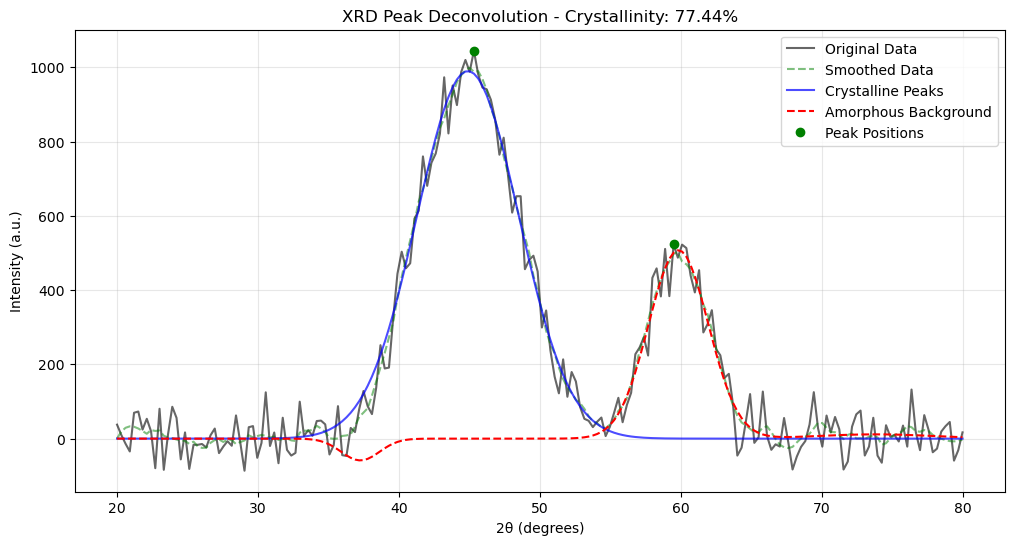

In [24]:
# --- Step 2: Smooth the Spectrum (Estimate Amorphous Background) ---
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# --- Step 3: Identify Crystalline Peaks ---
crystalline_peaks, _ = find_peaks(intensity, height=200, prominence=10, width=2)
crystalline_theta = two_theta[peaks]
crystalline_intensity = intensity[peaks]

# --- Step 4: Define Gaussian Function ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# --- Step 5: Fit Multiple Gaussian Peaks ---
def multi_gaussian(x, *params):
    num_peaks = len(params) // 3
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# Initial guess for Gaussian parameters: [A1, mu1, sigma1, A2, mu2, sigma2, ...]
init_guess = []
num_crystalline_peaks = len(crystalline_peaks)  # Dynamic number of Gaussian peaks
num_amorphous_peaks = max(3, min(7, int(num_crystalline_peaks / 2)))  # Rule of thumb

# Estimate parameters for crystalline peaks
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        init_guess += [crystalline_intensity[i], crystalline_theta[i], 0.5]  # A, mu, sigma

# Estimate parameters for amorphous background
amorphous_regions = np.linspace(two_theta.min(), two_theta.max(), num_amorphous_peaks)
for i in range(num_amorphous_peaks):
    init_guess += [np.mean(intensity), amorphous_regions[i], 5]  # Broader sigma for amorphous

# Curve fitting
popt, _ = curve_fit(multi_gaussian, two_theta, intensity, p0=init_guess)

# --- Step 6: Compute Crystalline and Amorphous Areas ---
crystalline_fit = multi_gaussian(two_theta, *popt[:3*num_crystalline_peaks])
amorphous_fit = multi_gaussian(two_theta, *popt[3*num_crystalline_peaks:])

Ac = np.trapz(crystalline_fit, two_theta)  # Area under crystalline peaks
Aa = np.trapz(amorphous_fit, two_theta)    # Area under amorphous background

Xc = (Ac / (Ac + Aa)) * 100  # Crystallinity Index

print(f"Crystallinity (Area Method): {Xc:.2f}%")

# 7. Visualize results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, 'k-', label='Original Data', alpha=0.6)
plt.plot(two_theta, smoothed_intensity, 'g--', label='Smoothed Data', alpha=0.5)
plt.plot(two_theta, crystalline_fit, 'b-', label='Crystalline Peaks', alpha=0.7)
plt.plot(two_theta, amorphous_fit, 'r--', label='Amorphous Background')
plt.plot(two_theta[crystalline_peaks], intensity[crystalline_peaks], 'go', label='Peak Positions')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title(f'XRD Peak Deconvolution - Crystallinity: {Xc:.2f}%')
plt.grid(True, alpha=0.3)
plt.show()


Crystallinity: -0.57%
R-squared: 0.9765
RMSE: 43.8227


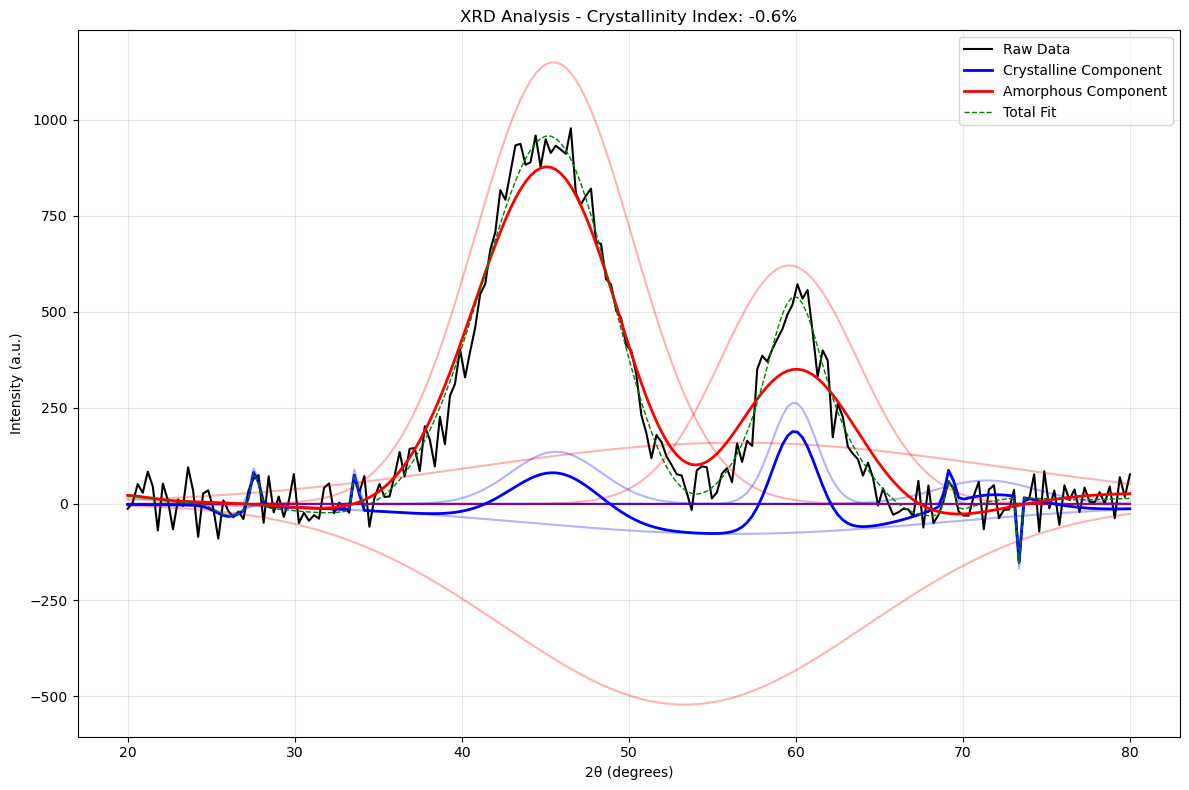

In [12]:
# --- Step 2: Smooth the Spectrum (Estimate Amorphous Background) ---
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# --- Step 3: Identify Crystalline Peaks ---
peaks, _ = find_peaks(intensity, height=smoothed_intensity+20, prominence=10, width=2)
crystalline_theta = two_theta[peaks]
crystalline_intensity = intensity[peaks]

# --- Step 4: Define Gaussian Function ---
def gaussian(x, A, x0, sigma):
    """
    Computes a Gaussian function.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        A : float
            The amplitude (peak height).
        x0 : float
            The center of the peak.
        sigma : float
            The standard deviation (controls peak width).

    Returns:
        Gaussian function values at x.
    """
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

# --- Step 5: Fit Multiple Gaussian Peaks ---
def multi_gaussian(x, *params):
    """
    Computes multiple Gaussian peaks by summing them.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        params : list of floats
            Parameters in the form (a1, x01, sigma1, a2, x02, sigma2, ..., an, x0n, sigman)
            for n Gaussian peaks.

    Returns:
        Sum of all Gaussian function values at x.
    """
    num_peaks = len(params) // 3    # Each peak has 3 parameters (a, x0, sigma)
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# First fit the amorphous background independently
def amorphous_background(x, *params):
    num_peaks = len(params) // 3
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# Smooth heavily to estimate background
background_smoothed = savgol_filter(intensity, window_length=51, polyorder=3)

# Fit amorphous background first
amorphous_params_guess = []
num_amorphous_peaks = 5 # specific to PEEK
amorphous_regions = np.linspace(two_theta.min(), two_theta.max(), num_amorphous_peaks)
for i in range(num_amorphous_peaks):
    amorphous_params_guess += [np.mean(intensity), amorphous_regions[i], 5]

amorphous_popt, _ = curve_fit(amorphous_background, two_theta, background_smoothed, 
                            p0=amorphous_params_guess)

# Subtract amorphous background to get crystalline component
amorphous_baseline = amorphous_background(two_theta, *amorphous_popt)
crystalline_component = intensity - amorphous_baseline

# Then fit crystalline peaks to the residual
crystalline_params_guess = []
num_crystalline_peaks = 9   # specific to PEEK
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        crystalline_params_guess += [crystalline_intensity[i], crystalline_theta[i], 0.5]

crystalline_popt, _ = curve_fit(multi_gaussian, two_theta, crystalline_component, 
                              p0=crystalline_params_guess)

# Combine results
popt = np.concatenate([crystalline_popt, amorphous_popt])

# --- Step 6: Compute Crystalline and Amorphous Areas ---
crystalline_fit = multi_gaussian(two_theta, *popt[:3*num_crystalline_peaks])
amorphous_fit = multi_gaussian(two_theta, *popt[3*num_crystalline_peaks:])

Ac = np.trapz(crystalline_fit, two_theta)  # Area under crystalline peaks
Aa = np.trapz(amorphous_fit, two_theta)    # Area under amorphous background

Xc = (Ac / (Ac + Aa)) * 100  # Crystallinity Index
print(f"Crystallinity: {Xc:.2f}%")

# Calculate R-squared and RMSE to evaluate fit quality
y_fit = multi_gaussian(two_theta, *popt)
residuals = intensity - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity - np.mean(intensity))**2)
r_squared = 1 - (ss_res / ss_tot)
rmse = np.sqrt(np.mean(residuals**2))

print(f"R-squared: {r_squared:.4f}")
print(f"RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 8))

# Plot raw data
plt.plot(two_theta, intensity, 'k-', label='Raw Data')

# Plot individual crystalline peaks
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        params = popt[3*i:3*i+3]
        peak_fit = gaussian(two_theta, *params)
        plt.plot(two_theta, peak_fit, 'b-', alpha=0.3)

# Plot individual amorphous peaks
for i in range(num_amorphous_peaks):
    j = num_crystalline_peaks + i
    params = popt[3*j:3*j+3]
    peak_fit = gaussian(two_theta, *params)
    plt.plot(two_theta, peak_fit, 'r-', alpha=0.3)

# Plot combined fits
plt.plot(two_theta, crystalline_fit, 'b-', label='Crystalline Component', linewidth=2)
plt.plot(two_theta, amorphous_fit, 'r-', label='Amorphous Component', linewidth=2)
plt.plot(two_theta, crystalline_fit + amorphous_fit, 'g--', label='Total Fit', linewidth=1)

plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title(f'XRD Analysis - Crystallinity Index: {Xc:.1f}%')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

Key features:
- **Separate Fitting Process**: Amorphous background is fitted first with broad Gaussians, then crystalline peaks are fitted to the residual. This improves accuracy by preventing the crystalline peaks from influencing the background fit.
- **Parameter Bounds**: Constrains the fitting parameters to physically meaningful values (e.g., preventing negative amplitudes, restricting peak positions, enforcing appropriate widths).
- **Error Handling**: Includes try-except blocks to handle potential fitting failures and provide fallback options.
- **Comprehensive Visualization**: Plots include raw data, fitted components, individual peaks, and peak markers for easy interpretation.
- **Results Summary**: Outputs crystallinity percentage along with the component areas for validation.

Amorphous background fitting successful
Crystalline peak fitting successful
Crystallinity: 23.82%

Results Summary:
           Parameter         Value
0  Crystallinity (%)     23.816159
1   Crystalline Area   3781.370949
2     Amorphous Area  12095.962154
3         Total Area  15877.333103


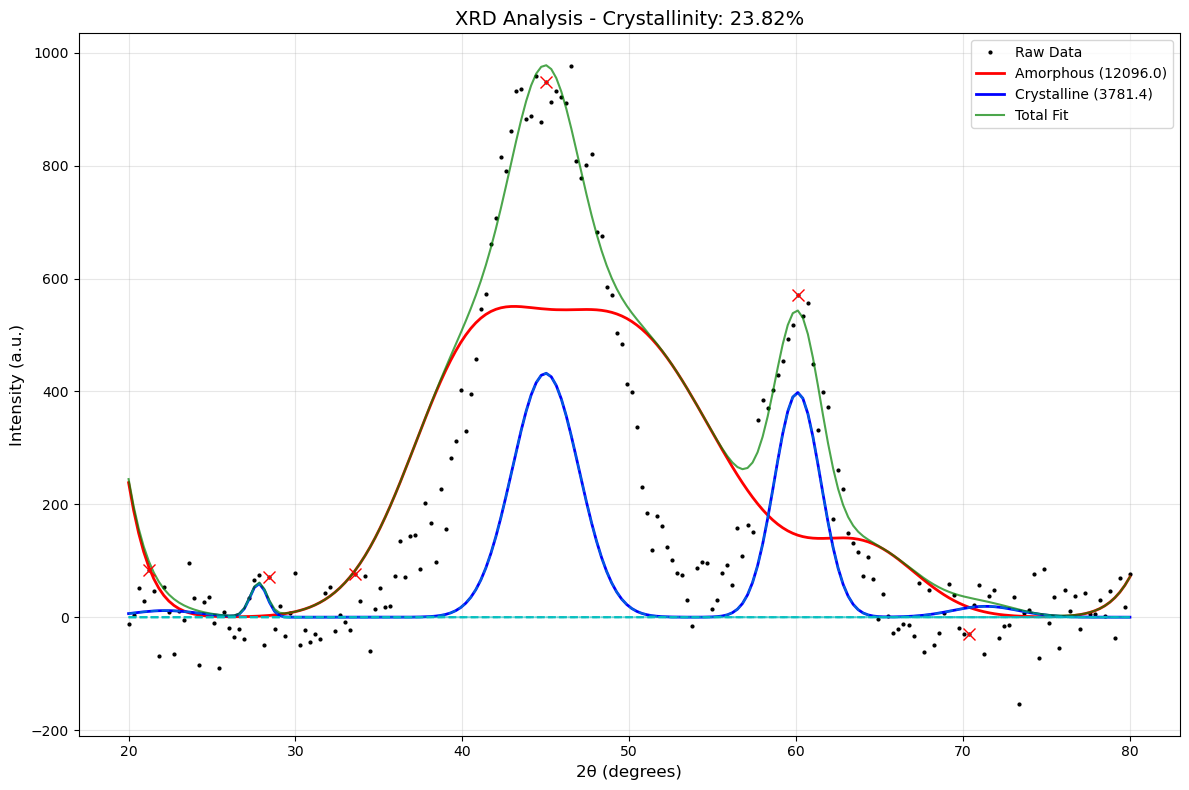

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid

# --- Step 1: Load and Visualize XRD Data ---


# --- Step 2: Data Preprocessing ---
# Smooth the data to reduce noise
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# Normalize data if needed
normalized_intensity = intensity / np.max(intensity)

# --- Step 3: Peak Detection ---
# Find peaks in the smoothed data
peaks, properties = find_peaks(smoothed_intensity, 
                              prominence=0.05,   # Adjust as needed
                              width=2,           # Adjust as needed
                              distance=10)       # Minimum distance between peaks

# Extract peak information
crystalline_theta = two_theta[peaks]
crystalline_intensity = smoothed_intensity[peaks]

# Visualize peak detection
plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, label='Original Data', alpha=0.5)
plt.plot(two_theta, smoothed_intensity, label='Smoothed Data', alpha=0.7)
plt.plot(two_theta[peaks], smoothed_intensity[peaks], 'ro', label='Detected Peaks')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title('XRD Peak Detection')
plt.grid(True, alpha=0.3)


# Main Analysis

## Data

In [3]:
import os

# Get all file names in the data directory
data_dir = "../data/XRD"  # Adjust this path to your data folder
all_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')]
print(f'File names: {all_files}')

File names: ['500907.csv', '500907_2.csv', '501023.csv', '501023_2.csv', '501024.csv', '501024_2.csv', 'HDPE.csv', 'HDPE_2.csv']


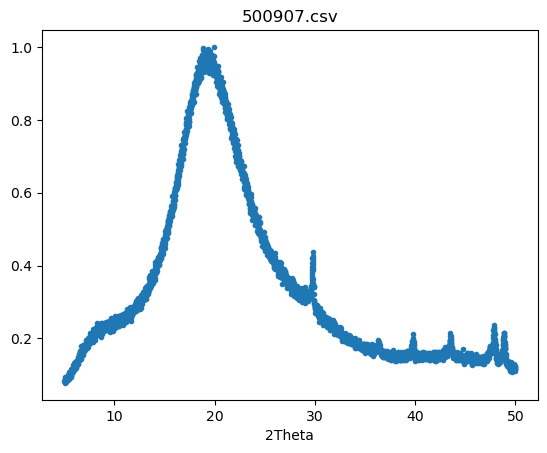

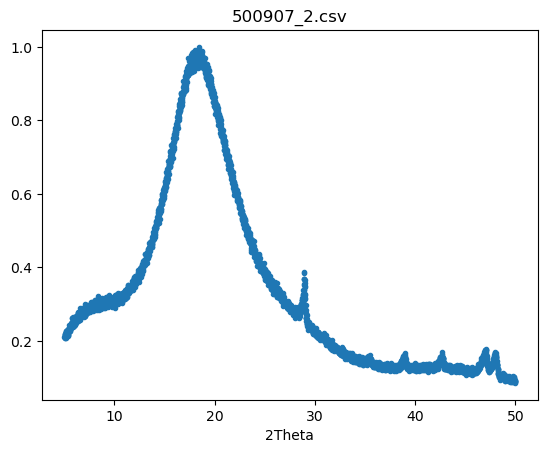

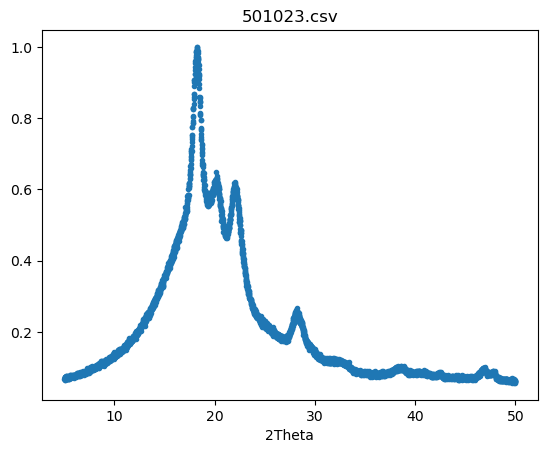

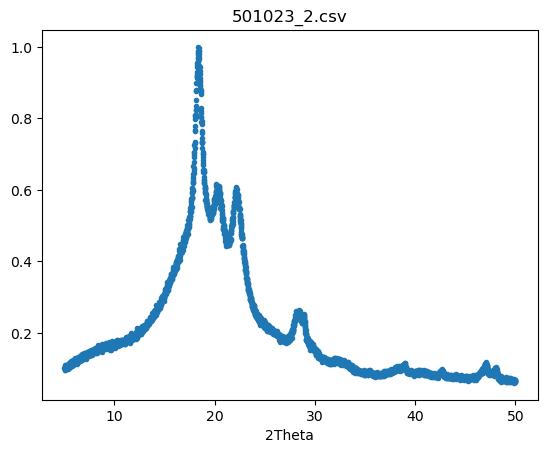

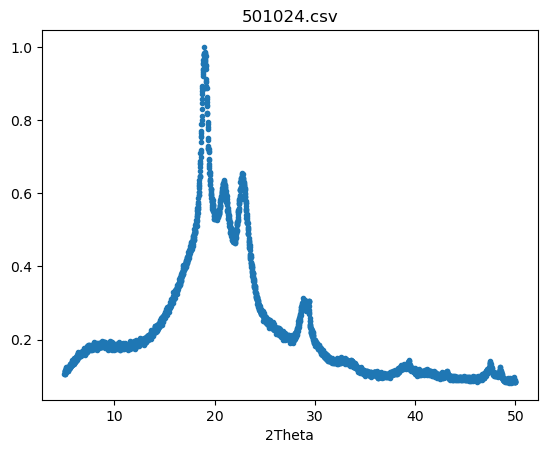

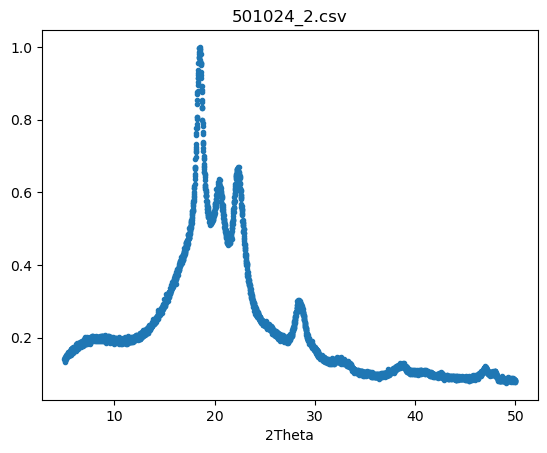

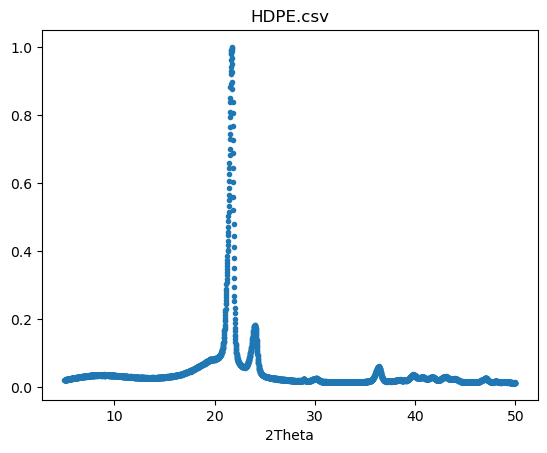

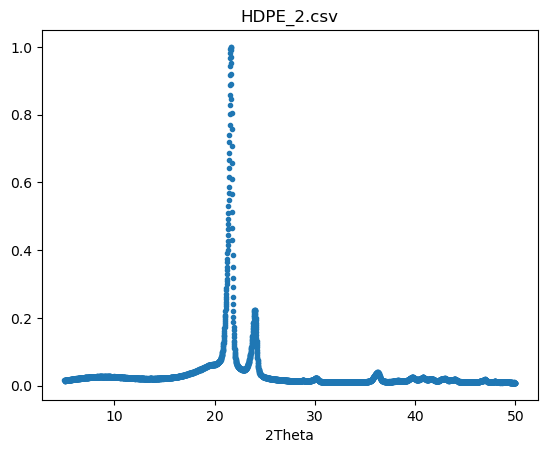

In [4]:
df_dict = {}
for file in all_files:
    df_dict[file] = pd.read_csv(os.path.join(data_dir, file), skiprows=21)
    df_dict[file].rename(columns={'Angle': '2Theta', ' Intensity': 'Intensity'}, inplace=True)
    df_dict[file]['Intensity_norm'] = df_dict[file]['Intensity'] / df_dict[file]['Intensity'].max()
    
    # Downsample data for faster peak detection
    # df_dict[file] = df_dict[file].iloc[::5, :]
    df_dict[file].plot(x='2Theta', y='Intensity_norm', title=f'{file}', legend=False, linestyle='None', marker='.')

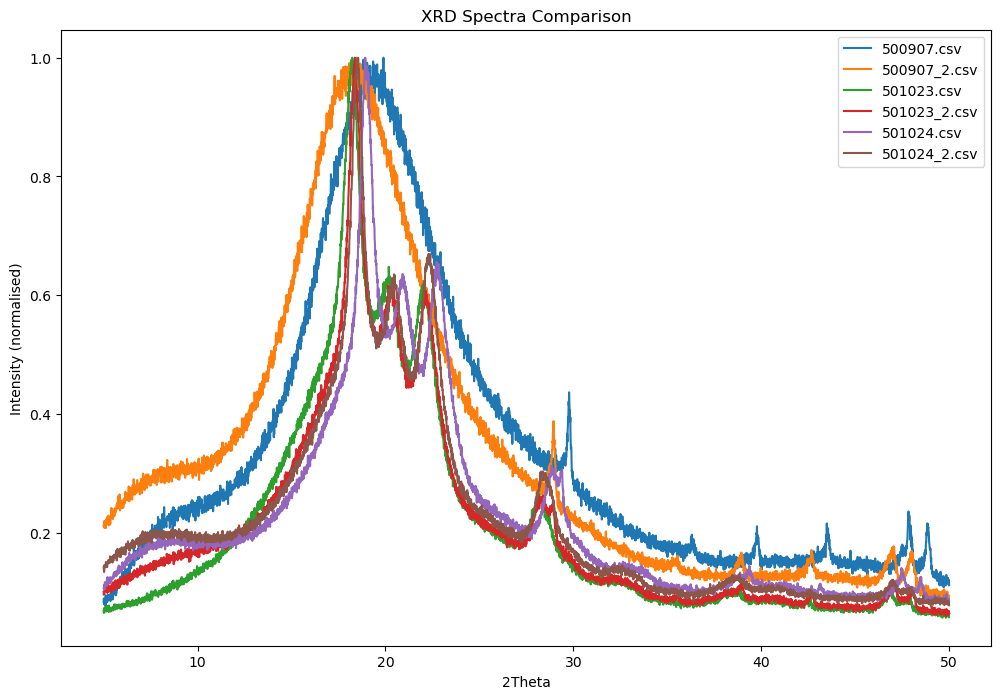

In [42]:
peek_files = [f for f in all_files if 'HDPE' not in f]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
for file in peek_files:
    ax.plot(df_dict[file]['2Theta'], df_dict[file]['Intensity_norm'], label=file)
ax.set_xlabel('2Theta')
ax.set_ylabel('Intensity (normalised)')
ax.set_title('XRD Spectra Comparison')
ax.legend()

## Analysis

### Method 1: Area-Based Crystallinity

Text(0.5, 1.0, 'XRD Peak Detection')

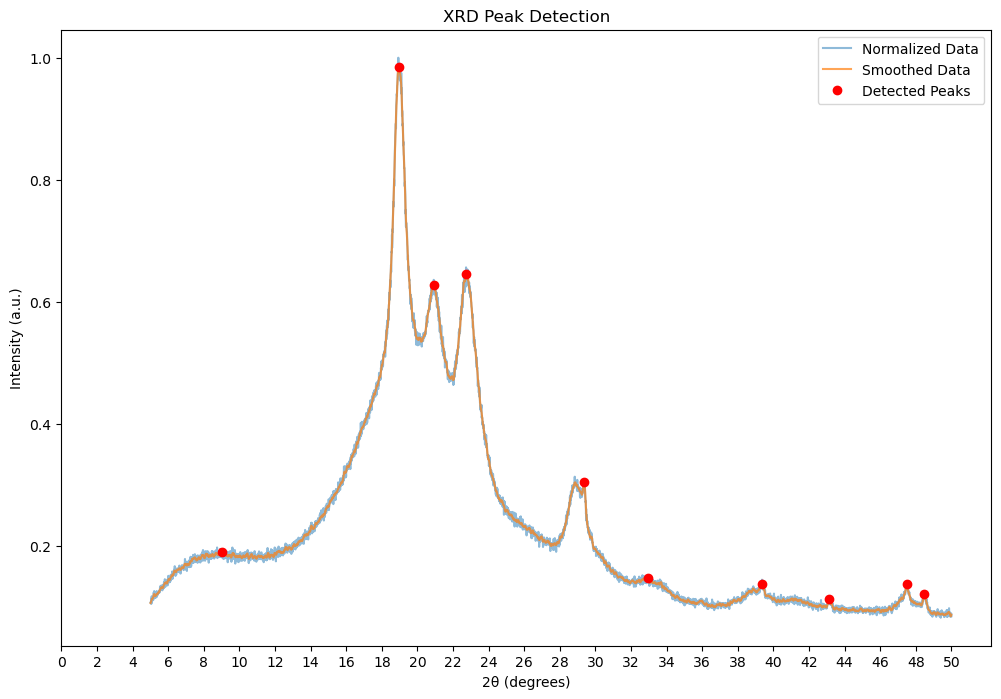

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid

# --- Step 1: Load XRD Data ---
data = df_dict['501024.csv']
intensity = data['Intensity_norm'].values
two_theta = data['2Theta'].values

# --- Step 1: Data Preprocessing ---
# Normalize intensity
normalized_intensity = intensity / np.max(intensity)

# Smooth the normalized data
smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)

# --- Step 2: Peak Detection ---
# First pass with less strict parameters to find major peaks
major_peaks, _ = find_peaks(smoothed_intensity, 
                            prominence=0.05,
                            width=20,
                            distance=50)

# Second pass with more sensitive settings to detect shoulders and overlaps
all_peaks, _ = find_peaks(smoothed_intensity,
                          prominence=0.008,  # Lower prominence
                          width=10,         # Lower width
                          distance=50)      # Smaller distance

# Use peak properties to get a better estimate of peak widths
_, properties = find_peaks(smoothed_intensity, 
                            prominence=0.01,
                            width=10,
                            distance=20,
                            rel_height=0.5)  # For width at half maximum

# Calculate peak widths in degrees
peak_widths_points = properties["widths"]
peak_distances = np.diff(two_theta)
avg_point_distance = np.mean(peak_distances)
peak_widths_degrees = peak_widths_points * avg_point_distance

# Extract peak information
peak_positions = two_theta[all_peaks]
peak_heights = smoothed_intensity[all_peaks]

# Visualize peak detection
plt.figure(figsize=(12, 8))
plt.plot(two_theta, normalized_intensity, label='Normalized Data', alpha=0.5)
plt.plot(two_theta, smoothed_intensity, label='Smoothed Data', alpha=0.7)
plt.plot(peak_positions, peak_heights, 'ro', label='Detected Peaks')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.xticks(np.arange(0, 51, 2))
plt.legend()
plt.title('XRD Peak Detection')


In [ ]:
# --- Step 3: Define Gaussian Functions ---
def gaussian(x, A, x0, sigma):
    """Gaussian function with parameters amplitude, center, and width"""
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

def multi_gaussian(x, *params):
    """Fit multiple Gaussian peaks simultaneously"""
    num_peaks = len(params) // 3
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        amp = params[3*i]
        center = params[3*i+1]
        width = params[3*i+2]
        y_fit += gaussian(x, amp, center, width)
    return y_fit

# --- Step 4: Set Up Initial Guesses with Potential Overlaps ---
init_guess = []

# Define known PEEK peak positions from literature
known_peek_peaks = [18.7, 20.8, 22.8, 28.9]  # Common peaks for PEEK in 2θ
known_peak_tolerance = 1.0  # Tolerance in degrees

# Add all detected peaks as potential crystalline components
for i in range(len(all_peaks)):
    # Check if this peak might be overlapping with others
    is_overlapping = False
    for j in range(len(all_peaks)):
        if i != j and abs(peak_positions[i] - peak_positions[j]) < 1.0:
            is_overlapping = True
            break
    
    # Determine appropriate width estimate
    if i < len(peak_widths_degrees):
        width_estimate = peak_widths_degrees[i]
        # Adjust width for overlapping peaks
        if is_overlapping:
            width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
    else:
        width_estimate = 0.5  # Default if width couldn't be determined
        
    # Add parameters [amplitude, position, width]
    init_guess.extend([peak_heights[i], peak_positions[i], width_estimate])

# Add known peaks that might have been missed
for known_pos in known_peek_peaks:
    if not any(abs(pos - known_pos) < known_peak_tolerance for pos in peak_positions):
        # Add with moderate height estimate based on nearby intensity
        nearby_idx = np.argmin(np.abs(two_theta - known_pos))
        height_estimate = smoothed_intensity[nearby_idx] * 0.8
        init_guess.extend([height_estimate, known_pos, 0.5])

# Add amorphous background peaks
amorphous_positions = [9, 19, 22, 29, 37]
num_amorphous_peaks = len(amorphous_positions)
mean_intensity = np.mean(smoothed_intensity)

for pos in amorphous_positions:
    init_guess.extend([mean_intensity/2, pos, 5.0]) # amplitude, position, width

# Count total peaks
num_detected_peaks = len(all_peaks)
num_added_known_peaks = sum(1 for pos in known_peek_peaks 
                            if not any(abs(p - pos) < known_peak_tolerance for p in peak_positions))
num_total_peaks = num_detected_peaks + num_added_known_peaks + num_amorphous_peaks

In [32]:
# --- Step 5: Set Up Boundary Constraints ---
bounds_low = []
bounds_high = []

# Bounds for detected peaks
for i in range(len(all_peaks)):
    is_overlapping = False
    for j in range(len(all_peaks)):
        if i != j and abs(peak_positions[i] - peak_positions[j]) < 1.0:
            is_overlapping = True
            break
    
    if is_overlapping:
        # More flexible position bounds for overlapping peaks
        bounds_low.extend([0, peak_positions[i] - 0.8, 0.1])
        bounds_high.extend([np.inf, peak_positions[i] + 0.8, 2.0])
    else:
        # Standard bounds for isolated peaks
        bounds_low.extend([0, peak_positions[i] - 0.5, 0.1])
        bounds_high.extend([np.inf, peak_positions[i] + 0.5, 2.0])

# Bounds for added known peaks
for known_pos in known_peek_peaks:
    if not any(abs(pos - known_pos) < known_peak_tolerance for pos in peak_positions):
        bounds_low.extend([0, known_pos - 0.5, 0.1])
        bounds_high.extend([np.inf, known_pos + 0.5, 2.0])

# Bounds for amorphous peaks
for i in range(num_amorphous_peaks):
    bounds_low.extend([0, amorphous_positions[i] - 5, 3.0])
    bounds_high.extend([np.inf, amorphous_positions[i] + 5, 15.0])



In [41]:
# --- Step 6: Perform Curve Fitting ---
try:
    popt, pcov = curve_fit(multi_gaussian, two_theta, smoothed_intensity, 
                            p0=init_guess, bounds=(bounds_low, bounds_high),
                            maxfev=1000)  # Increase maximum function evaluations
    print("Fitting successful")
except Exception as e:
    print(f"Fitting error: {e}")
    print("Falling back to initial guess parameters")
    popt = np.array(init_guess)

# --- Plot Fitting Results ---
# Calculate the fitted curve
# y_fit = multi_gaussian(two_theta, *popt)

# # Calculate R-squared to evaluate goodness of fit
# residuals = smoothed_intensity - y_fit
# ss_res = np.sum(residuals**2)
# ss_tot = np.sum((smoothed_intensity - np.mean(smoothed_intensity))**2)
# r_squared = 1 - (ss_res / ss_tot)
# rmse = np.sqrt(np.mean(residuals**2))

# # Plot the fit results
# plt.figure(figsize=(12, 8))
# plt.plot(two_theta, normalized_intensity, 'k.', markersize=2, alpha=0.5, label='Raw Data')
# plt.plot(two_theta, smoothed_intensity, 'b-', alpha=0.7, label='Smoothed Data')
# plt.plot(two_theta, y_fit, 'r-', linewidth=2, label='Overall Fit')

# # Plot individual peak components
# for i in range(num_total_peaks):
#     params = popt[i*3:i*3+3]
#     peak_fit = gaussian(two_theta, *params)
#     plt.plot(two_theta, peak_fit, '--', linewidth=1, alpha=0.3)

# plt.plot(peak_positions, peak_heights, 'go', label='Detected Peaks')
# plt.xlabel('2θ (degrees)', fontsize=12)
# plt.ylabel('Intensity (normalized)', fontsize=12)
# plt.title(f'XRD Peak Fitting (R²: {r_squared:.4f}, RMSE: {rmse:.4f})', fontsize=14)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

print(f"Goodness of fit: R² = {r_squared:.4f}, RMSE = {rmse:.4f}")
print(f"Number of peaks fitted: {num_total_peaks}")

Fitting successful
Goodness of fit: R² = 0.9990, RMSE = 0.0054
Number of peaks fitted: 15


In [83]:
# --- Step 7: Separate Components Based on Peak Width ---
# width_threshold = 2.0  # Threshold for distinguishing crystalline/amorphous
# height_threshold = 0.05  # Threshold for peak amplitude
hw_ratio_threshold = 0.2  # Threshold for distinguishing crystalline/amorphous

crystalline_params = []
amorphous_params = []

for i in range(0, len(popt), 3):    # Iterate over amplitude, center, width of each peak
    if i+2 >= len(popt):  # Ensure don't go out of bounds
        break
    
    # Extract parameters for this peak
    amp = popt[i]
    center = popt[i+1]
    width = popt[i+2]
    hw_ratio = amp / width  # Height-to-width ratio    
    print('hw_ratio:', hw_ratio)
    
    # Filter out insignificant peaks
    if amp < 0.001:
        continue
    
    # Classify peaks based on width
    if (hw_ratio > hw_ratio_threshold):
        # This is likely a crystalline peak
        crystalline_params.extend([amp, center, width])
    else:
        # This is likely an amorphous peak
        amorphous_params.extend([amp, center, width])

hw_ratio: 1.4237766017021137e-24
hw_ratio: 1.41794813854582
hw_ratio: 0.37642917448463786
hw_ratio: 0.5305432210933803
hw_ratio: 0.23666320349308428
hw_ratio: 0.027927130995814776
hw_ratio: 0.04005987919866421
hw_ratio: 0.0956419252700741
hw_ratio: 0.12969923134264924
hw_ratio: 0.027431697585121328
hw_ratio: 0.0343874590642441
hw_ratio: 0.12588845378370073
hw_ratio: 0.025008664852704983
hw_ratio: 0.03470991808262598
hw_ratio: 0.017123060351680913


In [84]:
# --- Step 8: Calculate Individual Components ---
crystalline_fit = multi_gaussian(two_theta, *crystalline_params) if crystalline_params else np.zeros_like(two_theta)
amorphous_fit = multi_gaussian(two_theta, *amorphous_params) if amorphous_params else np.zeros_like(two_theta)
total_fit = crystalline_fit + amorphous_fit

# --- Step 9: Calculate Crystallinity Index ---
area_crystalline = trapezoid(crystalline_fit, two_theta)
area_amorphous = trapezoid(amorphous_fit, two_theta)
area_total = area_crystalline + area_amorphous

crystallinity = (area_crystalline / area_total) * 100 if area_total > 0 else 0.0

# Print results
print(f"Crystallinity: {crystallinity:.2f}%")
print(f"Number of crystalline peaks: {len(crystalline_params)//3}")
print(f"Number of amorphous peaks: {len(amorphous_params)//3}")


Crystallinity: 8.15%
Number of crystalline peaks: 4
Number of amorphous peaks: 10


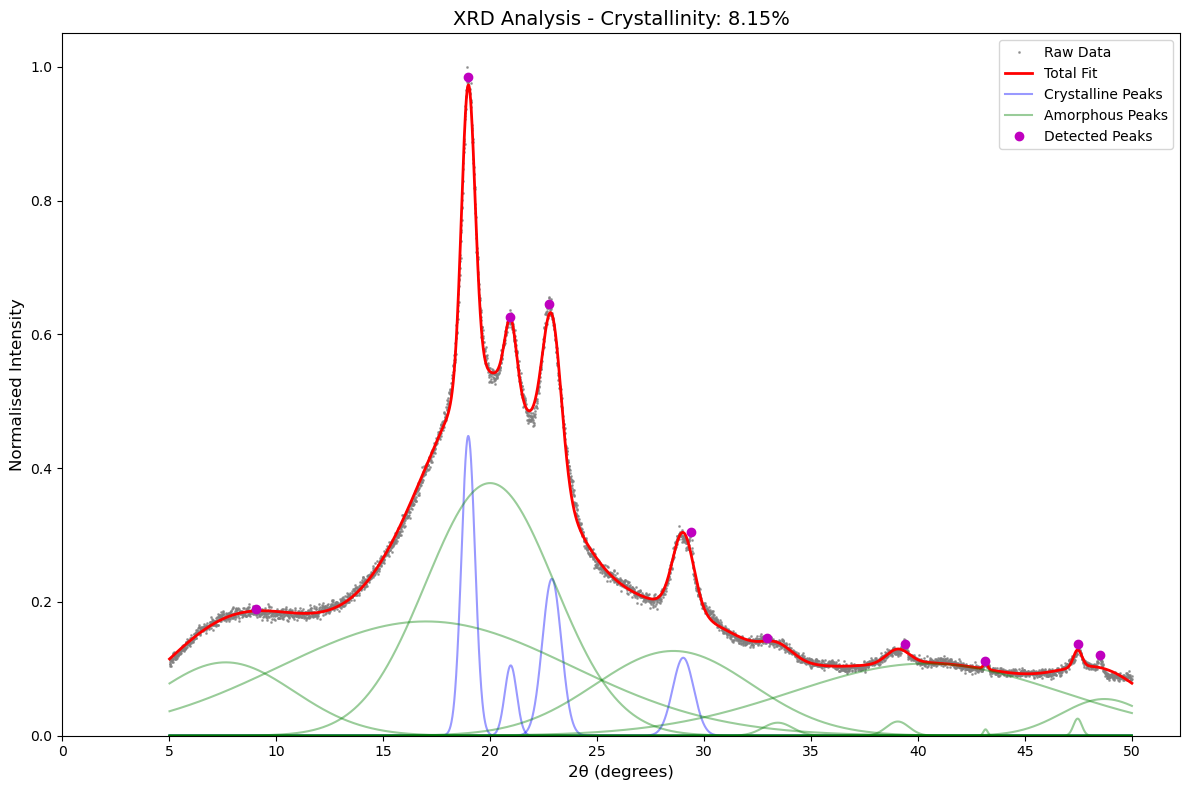

In [86]:
# --- Step 10: Visualization ---
plt.figure(figsize=(12, 8))

# Plot raw data and overall fit
plt.plot(two_theta, normalized_intensity, color='grey', linestyle='None', marker='.', markersize=2, alpha=0.7, label='Raw Data')
plt.plot(two_theta, total_fit, color='red', linestyle='-', label='Total Fit', linewidth=2)

# Plot individual crystalline peaks
for i in range(0, len(crystalline_params), 3):
    amp = crystalline_params[i]
    center = crystalline_params[i+1]
    width = crystalline_params[i+2]
    peak = gaussian(two_theta, amp, center, width)
    plt.plot(two_theta, peak, color='blue', linestyle='-', alpha=0.4, label=f'Crystalline Peaks' if i==0 else "")

# Plot individual amorphous peaks
for i in range(0, len(amorphous_params), 3):
    amp = amorphous_params[i]
    center = amorphous_params[i+1]
    width = amorphous_params[i+2]
    peak = gaussian(two_theta, amp, center, width)
    plt.plot(two_theta, peak, color='green', linestyle='-', alpha=0.4, label=f'Amorphous Peaks' if i==0 else "")

# Mark original detected peaks
plt.plot(two_theta[all_peaks], smoothed_intensity[all_peaks], 'mo', markersize=6, label='Detected Peaks')

plt.xlabel('2θ (degrees)', fontsize=12)
plt.ylabel('Normalised Intensity', fontsize=12)
plt.ylim(bottom=0)
plt.xticks(np.arange(0, 51, 5))
plt.title(f'XRD Analysis - Crystallinity: {crystallinity:.2f}%', fontsize=14)

# Create a cleaner legend with fewer entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [106]:
def fit_xrd_spectrum(two_theta, intensity, known_crys_peaks=None, known_amorp_peaks=None, 
                     height_width_threshold=0.2, visualise=True):
    """
    Comprehensive XRD analysis function with peak detection, baseline correction,
    Gaussian fitting, and crystallinity calculation.
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    intensity : array-like
        Array of corresponding intensity values
    known_crys_peaks : list or None, optional
        List of known crystalline peak positions from literature
        If None, empty list [] will be used
    known_amorp_peaks : list or None, optional
        List of known amorphous peak positions
        If None, empty list [] will be used
    height_width_threshold : float, default=0.2
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    visualise : bool, default=True
        Whether to generate visualization plots
        
    Returns:
    --------
    dict
        Dictionary containing peak information, fitted parameters, and crystallinity
    """
    # Set default values if None is provided
    if known_crys_peaks is None:
        known_crys_peaks = []  
        
    if known_amorp_peaks is None:
        known_amorp_peaks = []
    
    # --- Step 1: Data Preprocessing ---
    # Normalize intensity
    normalized_intensity = intensity / np.max(intensity)
    
    # Smooth the normalized data
    smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)
    
    # --- Step 2: Baseline Correction ---
    # Method: Find the minimum value of smoothed intensity as baseline level
    baseline_level = np.min(smoothed_intensity)
    
    # Subtract baseline level from smoothed intensity
    baseline_corrected_intensity = smoothed_intensity - baseline_level
    
    # Ensure no negative values
    baseline_corrected_intensity = np.maximum(baseline_corrected_intensity, 0)
    
    # Renormalize after baseline correction
    if np.max(baseline_corrected_intensity) > 0:
        baseline_corrected_intensity = baseline_corrected_intensity / np.max(baseline_corrected_intensity)
    
    # --- Step 3: Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=0.05,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=0.008,  # Lower prominence
                             width=10,         # Lower width
                             distance=50)      # Smaller distance
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=0.01,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks]
    peak_heights = baseline_corrected_intensity[all_peaks]
    
    # Calculate peak widths in degrees
    peak_widths_points = properties["widths"]
    peak_distances = np.diff(two_theta)
    avg_point_distance = np.mean(peak_distances)
    peak_widths_degrees = peak_widths_points * avg_point_distance
    
    # --- Step 4: Define Gaussian Functions ---
    def gaussian(x, A, x0, sigma):
        """Gaussian function with parameters amplitude, center, and width"""
        return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
    
    def multi_gaussian(x, *params):
        """Fit multiple Gaussian peaks simultaneously"""
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)
        for i in range(num_peaks):
            amp = params[3*i]
            center = params[3*i+1]
            width = params[3*i+2]
            y_fit += gaussian(x, amp, center, width)
        return y_fit
    
    # --- Step 5: Set Up Initial Guesses with Potential Overlaps ---
    init_guess = []
    
    # Set tolerance for peak matching
    known_peak_tolerance = 1.0  # Tolerance in degrees
    
    # Add all detected peaks as potential crystalline components
    for i in range(len(all_peaks)):
        # Check if this peak might be overlapping with others
        is_overlapping = False
        for j in range(len(all_peaks)):
            if i != j and abs(peak_positions[i] - peak_positions[j]) < 1.0:
                is_overlapping = True
                break
        
        # Determine appropriate width estimate
        if i < len(peak_widths_degrees):
            width_estimate = peak_widths_degrees[i]
            # Adjust width for overlapping peaks
            if is_overlapping:
                width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
        else:
            width_estimate = 0.5  # Default if width couldn't be determined
            
        # Add parameters [amplitude, position, width]
        init_guess.extend([peak_heights[i], peak_positions[i], width_estimate])
    
    # Add known crystalline peaks that might have been missed (if list is not empty)
    num_added_known_peaks = 0
    if known_crys_peaks:  # Only process if the list is not empty
        for known_pos in known_crys_peaks:
            if not any(abs(pos - known_pos) < known_peak_tolerance for pos in peak_positions):
                # Add with moderate height estimate based on nearby intensity
                nearby_idx = np.argmin(np.abs(two_theta - known_pos))
                height_estimate = baseline_corrected_intensity[nearby_idx] * 0.8
                init_guess.extend([height_estimate, known_pos, 0.5])
                num_added_known_peaks += 1
    
    # Add amorphous background peaks (if list is not empty)
    num_amorphous_peaks = 0
    if known_amorp_peaks:  # Only process if the list is not empty
        num_amorphous_peaks = len(known_amorp_peaks)
        mean_intensity = np.mean(baseline_corrected_intensity)
        
        for pos in known_amorp_peaks:
            init_guess.extend([mean_intensity/2, pos, 5.0]) # amplitude, position, width
    
    # Count total peaks
    num_detected_peaks = len(all_peaks)
    num_total_peaks = num_detected_peaks + num_added_known_peaks + num_amorphous_peaks
    
    # --- Step 6: Set up boundary constraints ---
    bounds_low = []
    bounds_high = []
    
    # Bounds for detected peaks
    for i in range(len(all_peaks)):
        is_overlapping = False
        for j in range(len(all_peaks)):
            if i != j and abs(peak_positions[i] - peak_positions[j]) < 1.0:
                is_overlapping = True
                break
        
        if is_overlapping:
            # More flexible position bounds for overlapping peaks
            bounds_low.extend([0, peak_positions[i] - 0.8, 0.1])
            bounds_high.extend([np.inf, peak_positions[i] + 0.8, 2.0])
        else:
            # Standard bounds for isolated peaks
            bounds_low.extend([0, peak_positions[i] - 0.5, 0.1])
            bounds_high.extend([np.inf, peak_positions[i] + 0.5, 2.0])
    
    # Bounds for added known peaks
    if known_crys_peaks:
        for known_pos in known_crys_peaks:
            if not any(abs(pos - known_pos) < known_peak_tolerance for pos in peak_positions):
                bounds_low.extend([0, known_pos - 0.5, 0.1])
                bounds_high.extend([np.inf, known_pos + 0.5, 2.0])
    
    # Bounds for amorphous peaks
    if known_amorp_peaks:
        for pos in known_amorp_peaks:
            bounds_low.extend([0, pos - 5, 3.0])
            bounds_high.extend([np.inf, pos + 5, 15.0])
    
    # --- Step 7: Perform Gaussian Fitting ---
    try:
        popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                              p0=init_guess, bounds=(bounds_low, bounds_high),
                              maxfev=20000)  # Increase maximum function evaluations
        print("Fitting successful")
    except Exception as e:
        print(f"Fitting error: {e}")
        print("Falling back to initial guess parameters")
        popt = np.array(init_guess)
    
    # --- Step 8: Separate Components Based on Height-to-Width Ratio ---
    crystalline_params = []
    amorphous_params = []
    
    for i in range(0, len(popt), 3):
        if i+2 >= len(popt):  # Safety check
            break
            
        amp = popt[i]
        center = popt[i+1]
        width = popt[i+2]
        hw_ratio = amp / width  # Height-to-width ratio
        
        # Skip peaks with near-zero amplitude
        if amp < 0.001:
            continue
            
        if hw_ratio > height_width_threshold:
            # This is likely a crystalline peak
            crystalline_params.extend([amp, center, width])
        else:
            # This is likely an amorphous peak
            amorphous_params.extend([amp, center, width])
    
    # --- Step 9: Calculate Individual Components ---
    crystalline_fit = multi_gaussian(two_theta, *crystalline_params) if crystalline_params else np.zeros_like(two_theta)
    amorphous_fit = multi_gaussian(two_theta, *amorphous_params) if amorphous_params else np.zeros_like(two_theta)
    total_fit = crystalline_fit + amorphous_fit
    
    # --- Step 10: Calculate Crystallinity Index ---
    area_crystalline = np.trapz(crystalline_fit, two_theta)
    area_amorphous = np.trapz(amorphous_fit, two_theta)
    area_total = area_crystalline + area_amorphous
    
    if area_total > 0:
        crystallinity = (area_crystalline / area_total) * 100
    else:
        crystallinity = 0.0
    
    # --- Step 11: Calculate Goodness of Fit ---
    residuals = baseline_corrected_intensity - total_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((baseline_corrected_intensity - np.mean(baseline_corrected_intensity))**2)
    r_squared = 1 - (ss_res / ss_tot)
    rmse = np.sqrt(np.mean(residuals**2))
    
    # --- Step 12: Visualization ---
    if visualise:
        # Plot peak detection results
        plt.figure(figsize=(12, 10))
        plt.subplot(3, 1, 1)
        plt.plot(two_theta, normalized_intensity, 'k-', label='Raw Data', alpha=0.5)
        plt.plot(two_theta, smoothed_intensity, 'b-', label='Smoothed Data')
        plt.axhline(y=baseline_level, color='r', linestyle='--', label='Baseline Level')
        plt.xlabel('2θ (degrees)')
        plt.ylabel('Intensity (a.u.)')
        plt.title('XRD Raw Data and Baseline')
        plt.legend()
        plt.grid(alpha=0.3)
        
        plt.subplot(3, 1, 2)
        plt.plot(two_theta, baseline_corrected_intensity, 'b-', label='Baseline Corrected')
        plt.plot(two_theta[major_peaks], baseline_corrected_intensity[major_peaks], 'ro', 
                label='Major Peaks', markersize=8)
        plt.plot(two_theta[all_peaks], baseline_corrected_intensity[all_peaks], 'go', 
                label='All Detected Peaks', markersize=6)
        
        # Mark known crystalline peaks (if list is not empty)
        if known_crys_peaks:
            for pos in known_crys_peaks:
                plt.axvline(x=pos, color='blue', linestyle='--', alpha=0.5)
                
        # Mark known amorphous peaks (if list is not empty)
        if known_amorp_peaks:
            for pos in known_amorp_peaks:
                plt.axvline(x=pos, color='red', linestyle=':', alpha=0.5)
            
        plt.xlabel('2θ (degrees)')
        plt.ylabel('Intensity (a.u.)')
        plt.title('XRD Peak Detection (Baseline Corrected)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Plot fitting results
        plt.subplot(3, 1, 3)
        # Plot raw data and overall fit
        plt.plot(two_theta, baseline_corrected_intensity, 'k-', alpha=0.7, label='Baseline Corrected Data')
        plt.plot(two_theta, total_fit, 'r-', label='Total Fit', linewidth=2)
        plt.plot(two_theta, crystalline_fit, 'b-', label='Crystalline Component', linewidth=1.5)
        plt.plot(two_theta, amorphous_fit, 'g-', label='Amorphous Component', linewidth=1.5)

        # Plot individual peaks
        for i in range(0, len(crystalline_params), 3):
            amp = crystalline_params[i]
            center = crystalline_params[i+1]
            width = crystalline_params[i+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'b--', alpha=0.4)

        for i in range(0, len(amorphous_params), 3):
            amp = amorphous_params[i]
            center = amorphous_params[i+1]
            width = amorphous_params[i+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'g--', alpha=0.4)

        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.ylim(bottom=0)
        plt.xlim(left=min(two_theta), right=max(two_theta))
        plt.title(f'XRD Fitting - Crystallinity: {crystallinity:.2f}% - R²: {r_squared:.4f}', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # --- Step 13: Return Results ---
    results = {
        'normalized_intensity': normalized_intensity,
        'smoothed_intensity': smoothed_intensity,
        'baseline_level': baseline_level,
        'baseline_corrected_intensity': baseline_corrected_intensity,
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'optimized_parameters': popt,
        'crystalline_params': crystalline_params,
        'amorphous_params': amorphous_params,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'total_fit': total_fit,
        'crystallinity': crystallinity,
        'r_squared': r_squared,
        'rmse': rmse,
        'residuals': residuals,
        'gaussian_function': gaussian,
        'multi_gaussian_function': multi_gaussian
    }
    
    return results

In [107]:
known_crys_peaks_dict = {
    'PEEK': [18.7, 20.8, 22.8, 28.9],
    'HDPE': [14.2, 16.8, 19.4, 24.1]
}

known_amorp_peaks_dict = {
    'PEEK': [9, 19, 22, 29, 37],
    'HDPE': [14, 17, 20, 24, 30]
}

Processing file: 500907.csv
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters


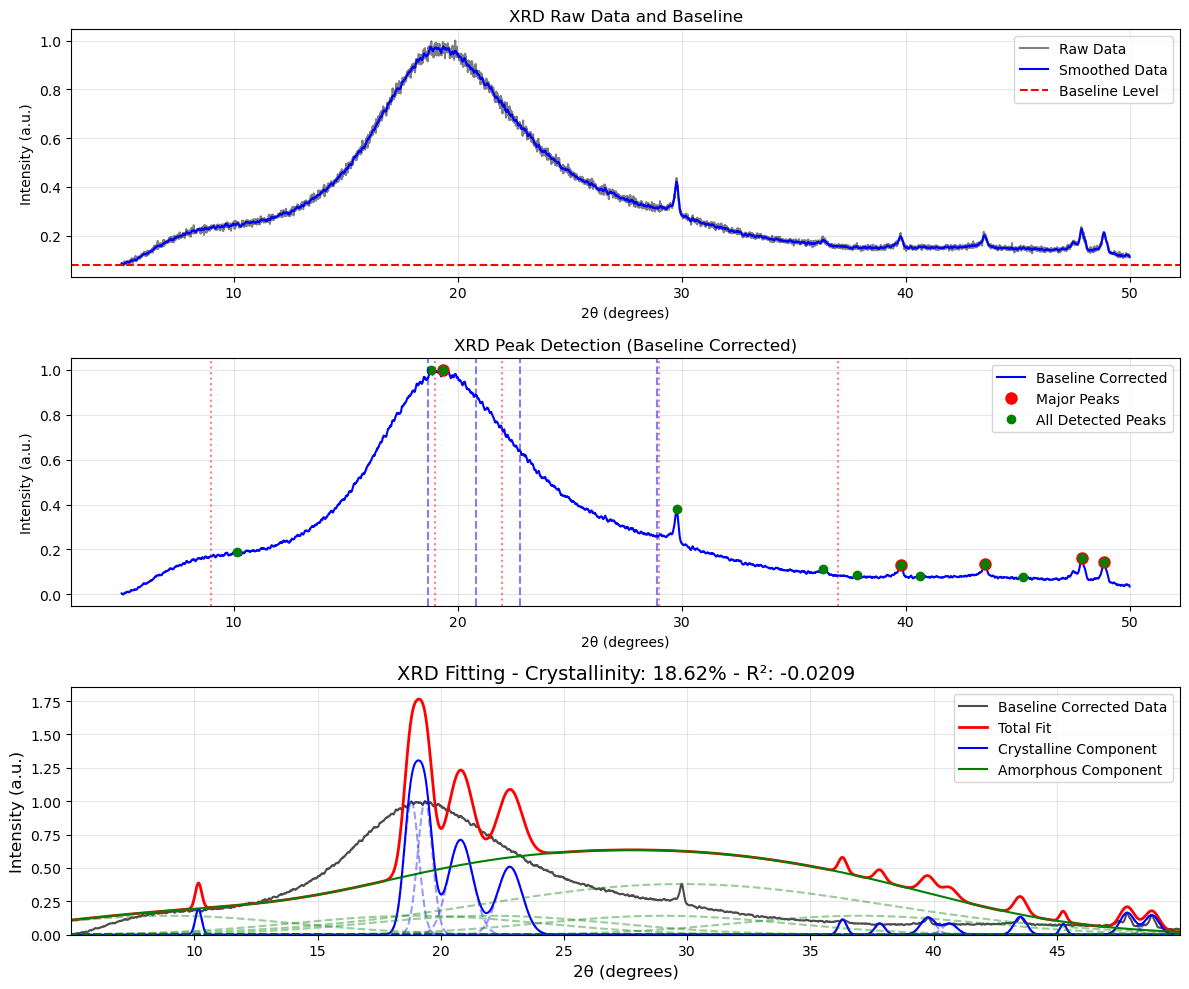

Processing file: 500907_2.csv
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters


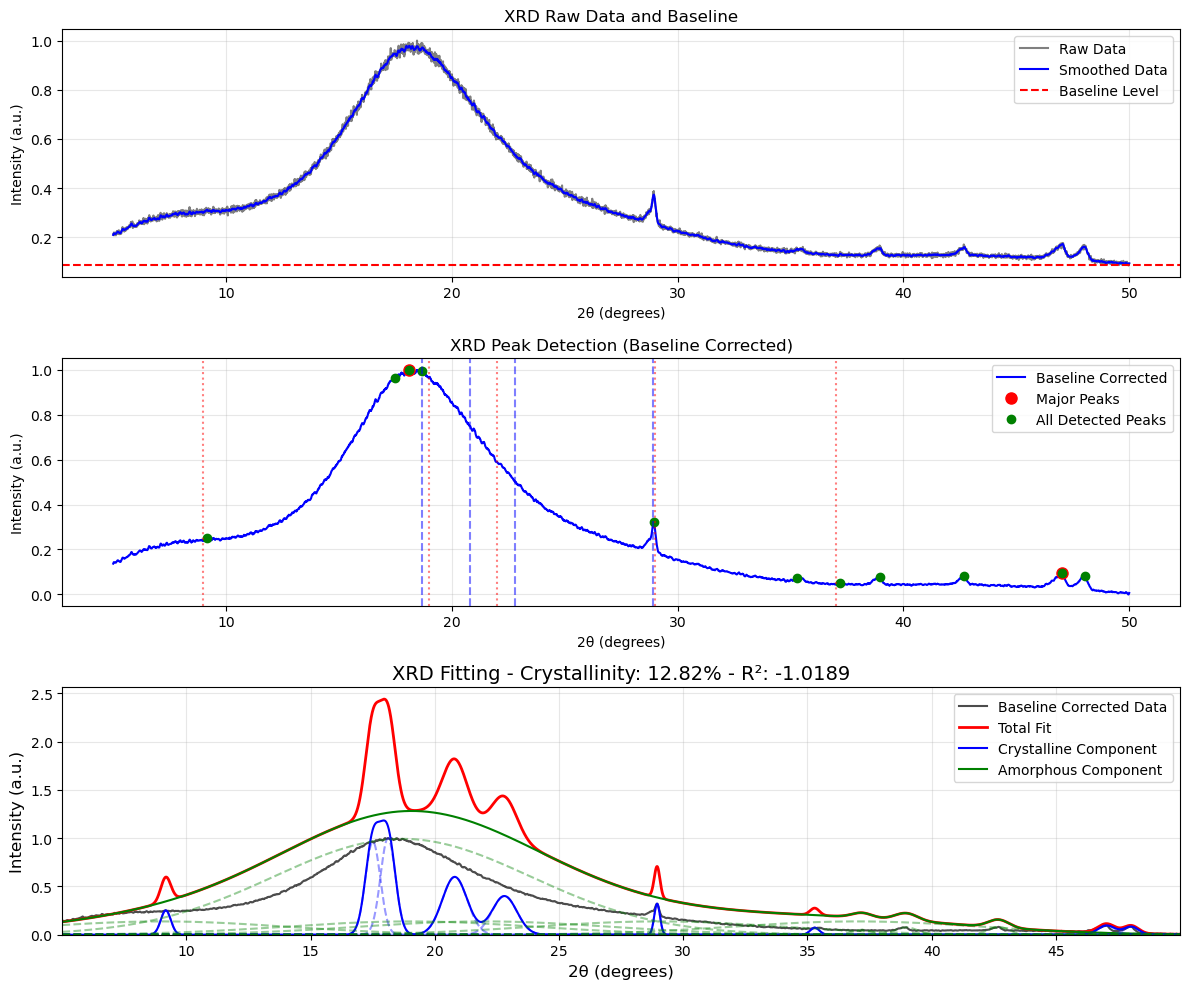

Processing file: 501023.csv
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters


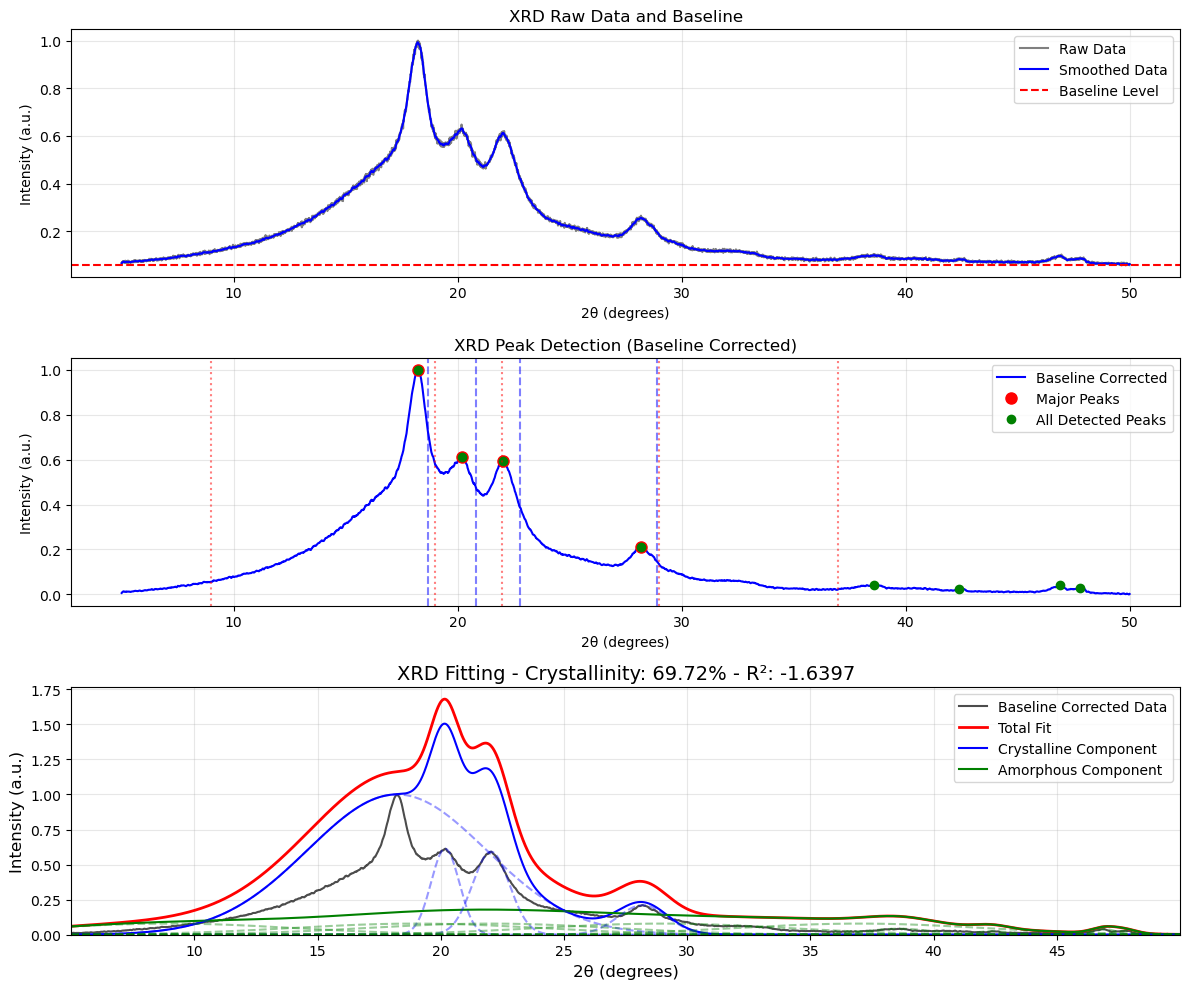

Processing file: 501023_2.csv
Fitting successful


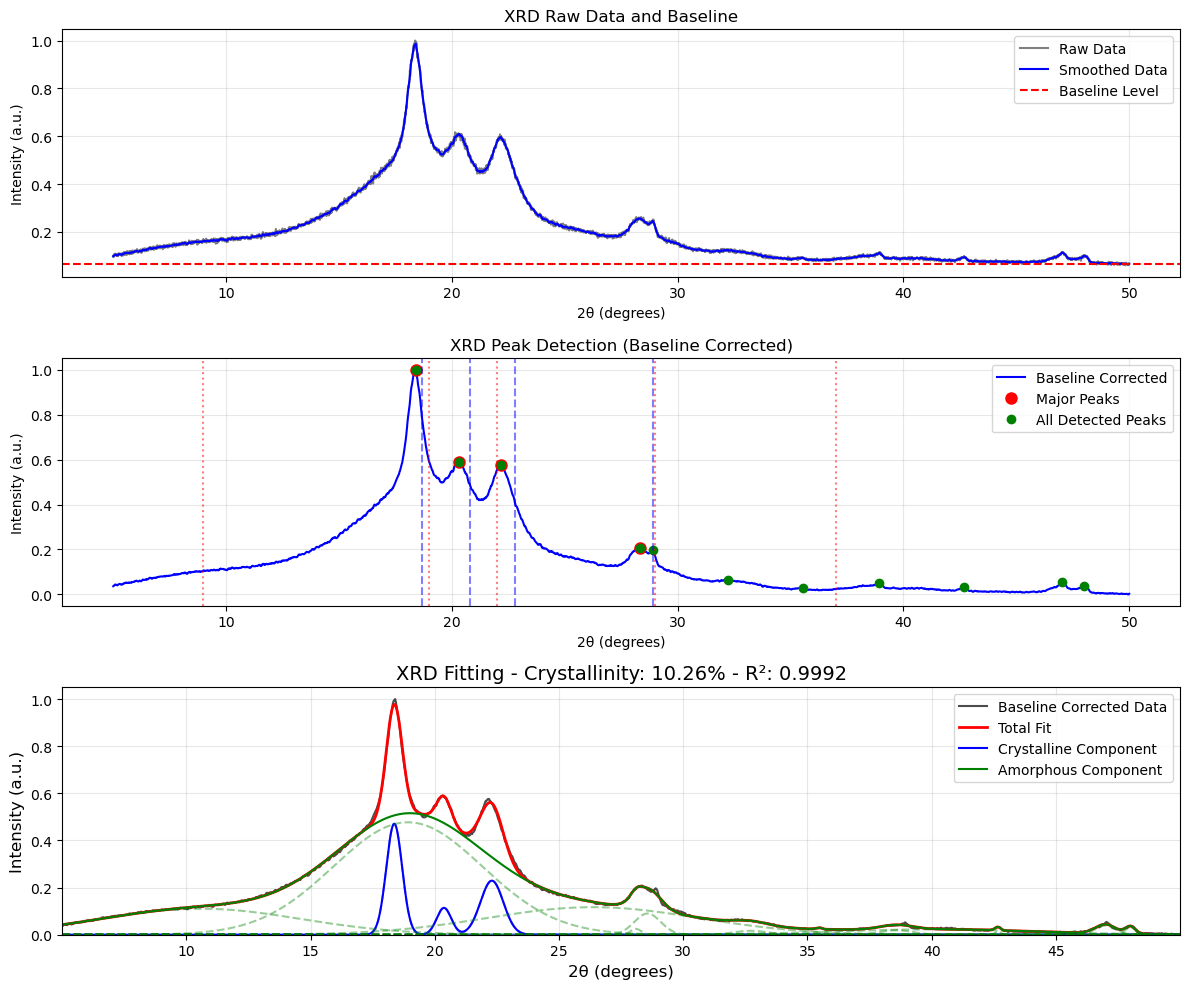

Processing file: 501024.csv
Fitting successful


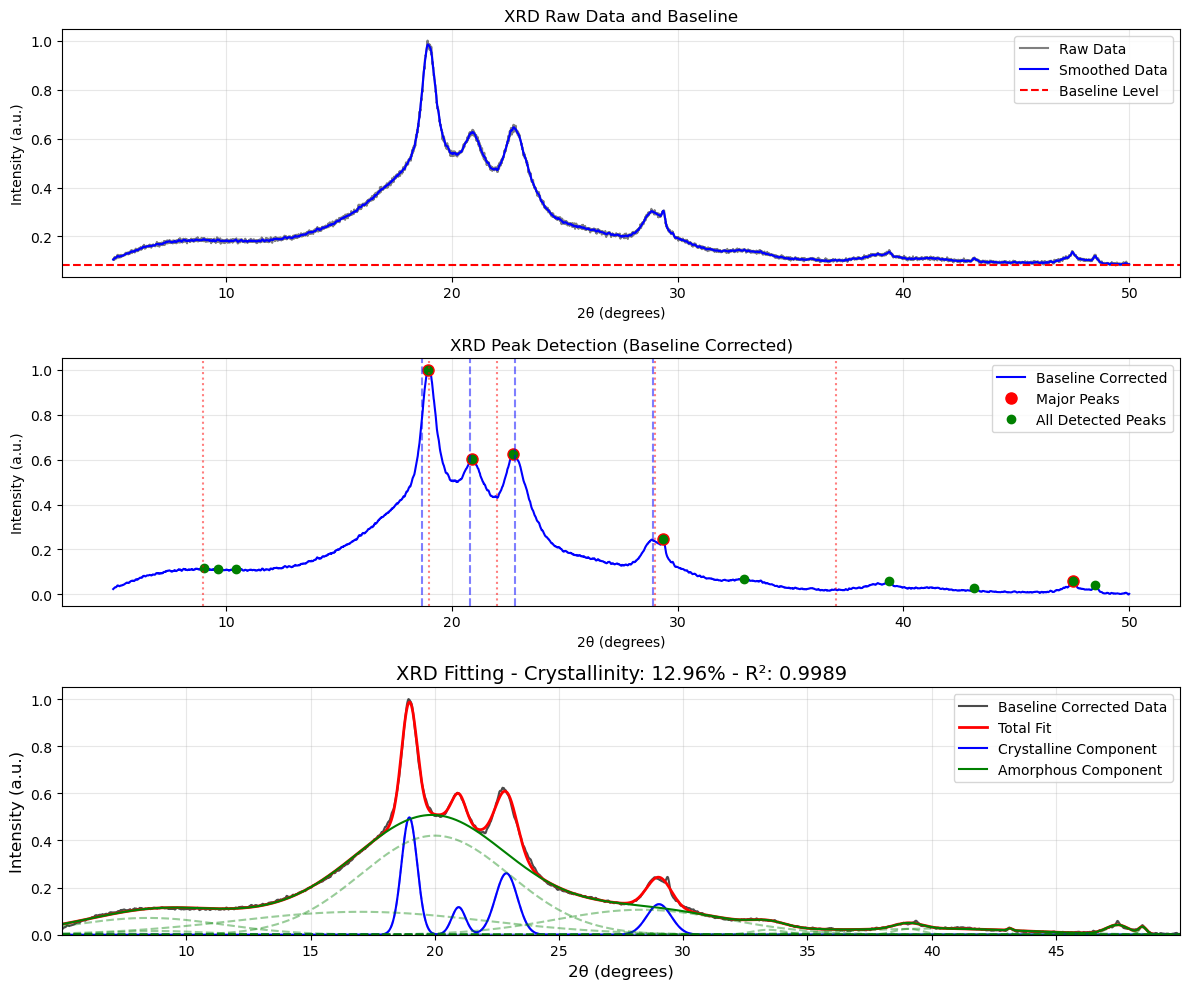

Processing file: 501024_2.csv
Fitting successful


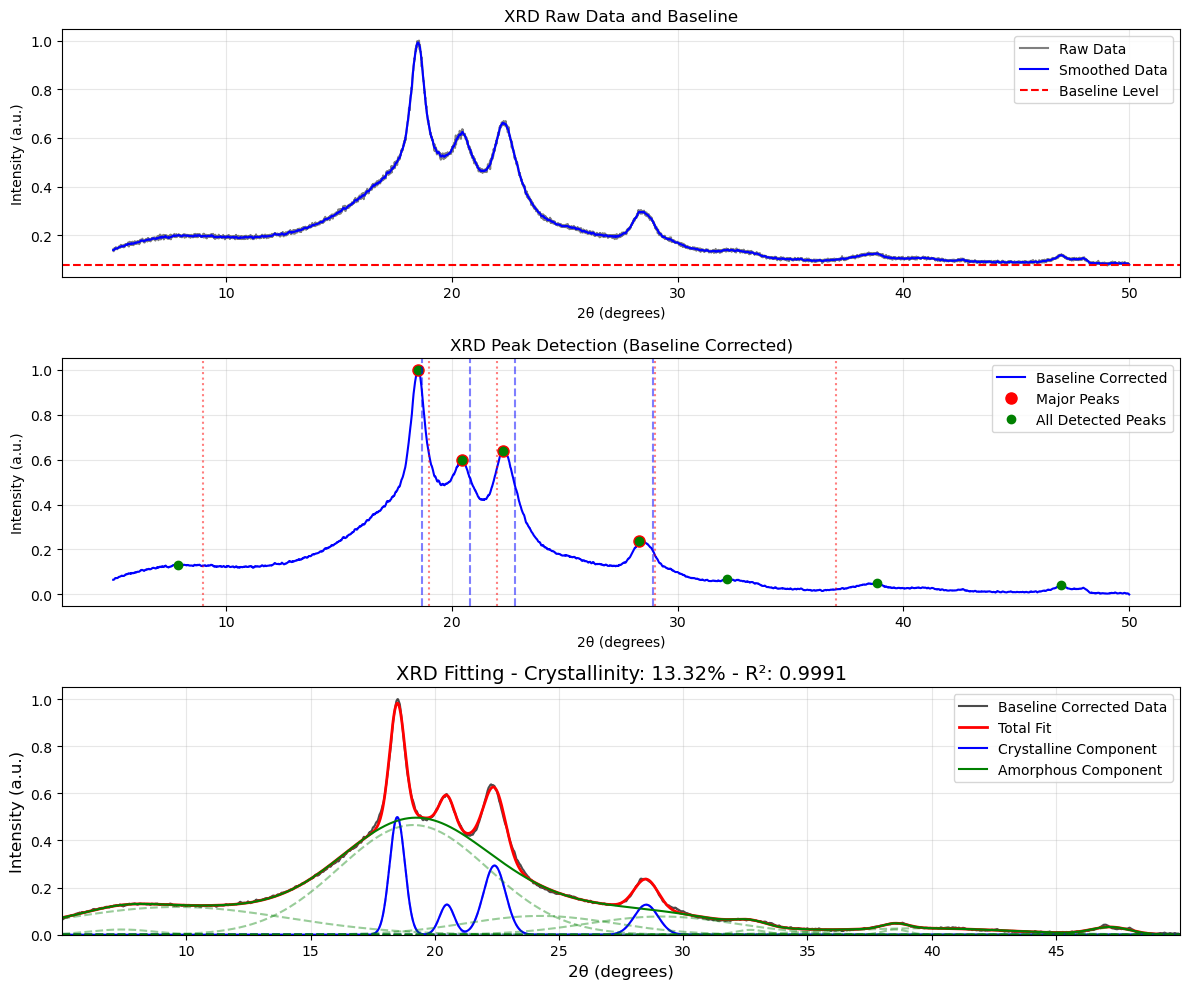

Processing file: HDPE.csv
Fitting successful


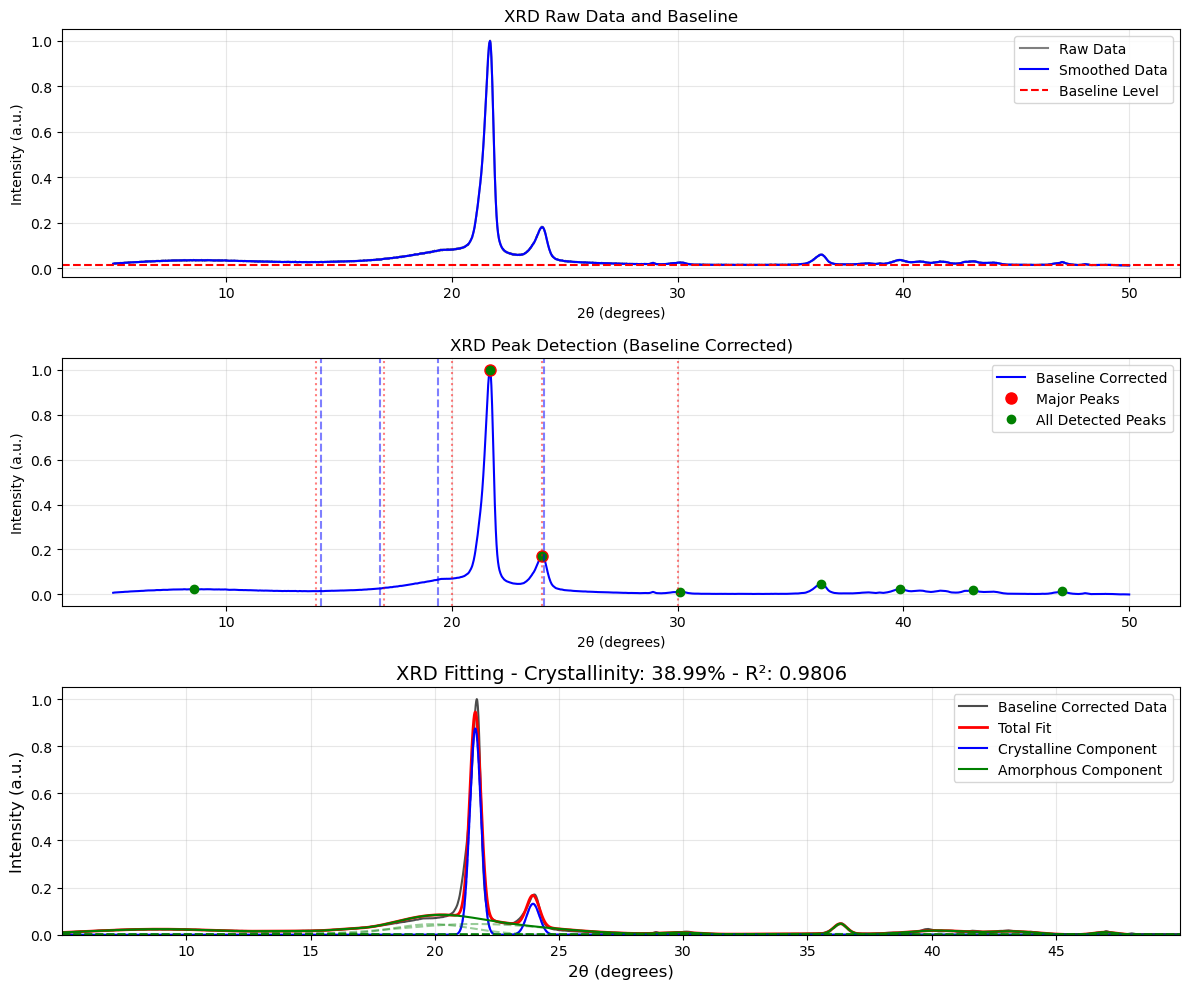

Processing file: HDPE_2.csv
Fitting successful


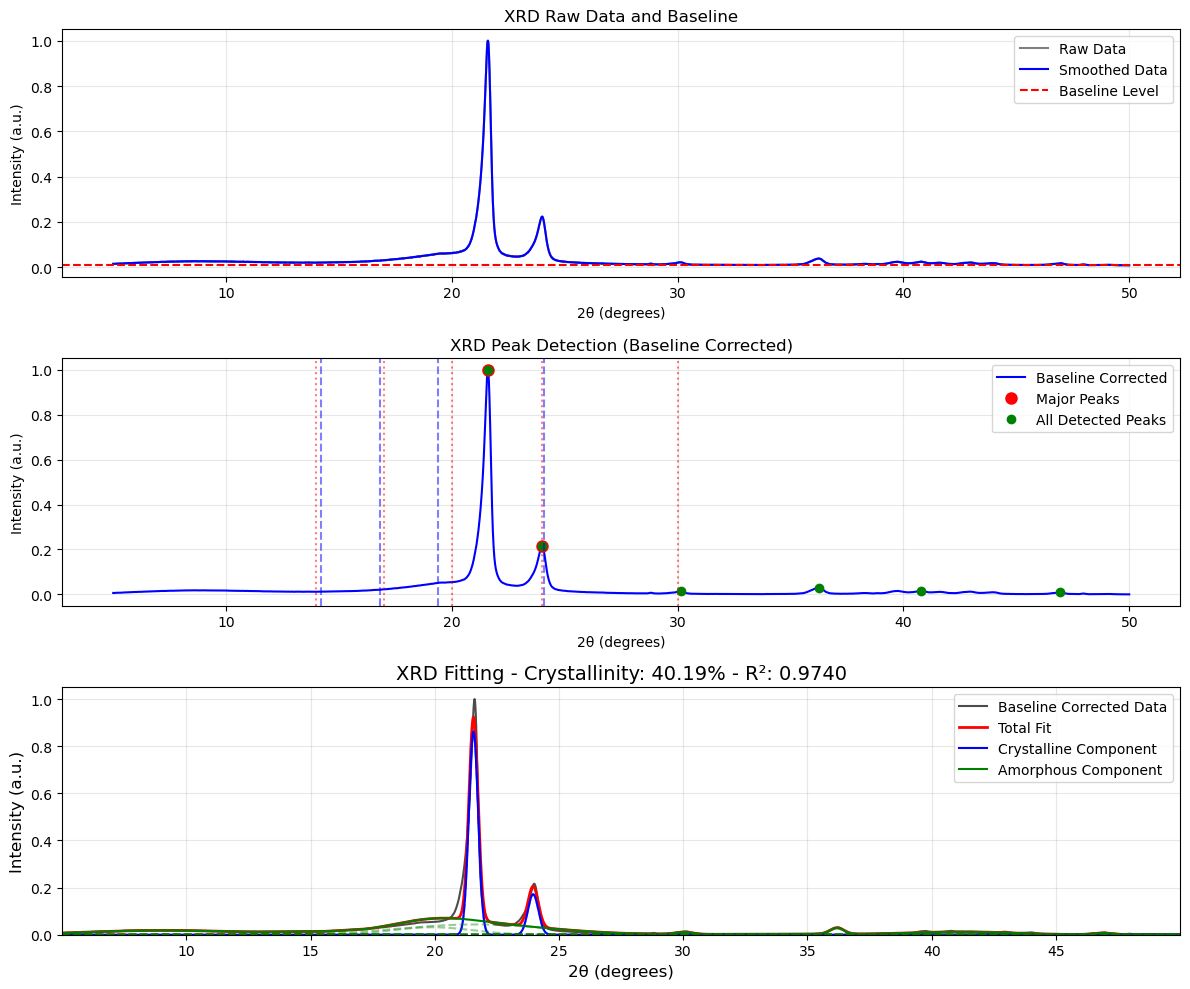

In [108]:
cryst_dict = {}
for file in all_files:
    print(f"Processing file: {file}")
    if 'HDPE' in file:
        polymer = 'HDPE'
    else:
        polymer = 'PEEK'
    data = df_dict[file]
    intensity = data['Intensity_norm'].values
    two_theta = data['2Theta'].values
    
    results = fit_xrd_spectrum(two_theta, intensity, 
                               known_crys_peaks=known_crys_peaks_dict.get(polymer, None),
                               known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
                               height_width_threshold=0.2, visualise=True)
    
    cryst_dict[file] = results['crystallinity']